<a href="https://colab.research.google.com/github/hevertton/valvesignature/blob/main/Assinatura_Valvula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise Anomalia Assinatura de Válvula Gaveta Submarina

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
#from IPython.display import display, HTML

In [3]:
import plotly.express as px

In [299]:
import seaborn as sns

In [5]:
!pip install pyod

In [6]:
import scipy
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.ensemble import IsolationForest 
from sklearn.neighbors import LocalOutlierFactor 
# Importando o modulo SVM do PyOD
from pyod.models.ocsvm import OCSVM 
# Importando funções de avaliação dos modelos
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.preprocessing import StandardScaler
%matplotlib inline 
import warnings 
warnings.filterwarnings('ignore')

# set seed
np.random.seed(123)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
dataset = pd.read_csv("/content/drive/My Drive/Histórico Válvula/dados_unicos_sem_escalonamento.csv", 
                      sep=';', encoding='latin-1')

In [9]:
dataset.head(6)

,poco_id,poco_nome,valvula_id,valvula_nome,id,cod,descrição,sigValvePosition,sigDate,sigTime,sigData1,sigData2,sigData3,sigData4,sigData5,sigData6,sigData7,sigData8,sigData9,sigData10,sigData11,sigData12,sigData13,sigData14,sigData15,sigData16,sigData17,sigData18,sigData19,sigData20,sigData21,sigData22,sigData23,sigData24,sigData25,sigData26,sigData27,sigData28,sigData29,sigData30,...,sigData82,sigData83,sigData84,sigData85,sigData86,sigData87,sigData88,sigData89,sigData90,sigData91,sigData92,sigData93,sigData94,sigData95,sigData96,sigData97,sigData98,sigData99,sigData100,sigData101,sigData102,sigData103,sigData104,sigData105,sigData106,sigData107,sigData108,sigData109,sigData110,sigData111,sigData112,sigData113,sigData114,sigData115,sigData116,sigData117,sigData118,sigData119,sigData120,Laudo
0,Well 1,?,PMV-1210218A,Production Master Valve 2 [M2],3,6003,Cur. Close Pressure Function Line,0,20090914 17:46,60,"-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771",...,"1360,152466","1273,069611","1190,133545","1107,197273","1028,407997","953,7655106","883,2698135","812,7740479","746,425209","684,2230911","626,1677628","568,1124687","514,2039986","464,442318","414,6806374","369,0657806","327,5977135","286,1296463","248,8083858","215,6339493","182,4594784","153,4318485","124,4041929","99,52336121","78,78931904","58,05528975","41,46806717","29,02764487","16,58722579","8,293612897","4,146806449",0,0,0,0,0,0,0,0,NaN
1,Well 1,?,PMV-1210218A,Production Master Valve 2 [M2],3,8003,Cur. Close Flow,0,20090914 17:46,60,0,"0,002573282","0,005188067","0,008549935","0,01224384","0,016269779","0,020461738","0,024819717","0,029302206","0,033826202","0,038391698","0,043040209","0,047605705","0,052212711","0,056778211","0,061260704","0,065701686","0,070101164","0,074417643","0,078692608","0,082884565","0,087076522","0,091226973","0,095377438","0,099527888","0,103678338","0,107828788","0,111979254","0,116129704","0,120280154",...,"0,336103767","0,340254217","0,344404697","0,348555118","0,352705598","0,356856018","0,361006498","0,365156919","0,369307399","0,373457879","0,377608299","0,381758779","0,3859092","0,39005968","0,394168586","0,398194551","0,40188846","0,405125827","0,407823622","0,409898818","0,411434501","0,412555128","0,413343728","0,413883269","0,414256811","0,414505839","0,414630353","0,414754868","0,414796352","0,414837867","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382",NaN
2,Well 1,?,PMV-1210218A,Production Master Valve 2 [M2],3,16003,Cur. Close Pressure Returne Line,0,20090914 17:46,60,"2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","4,146806717","6,911344528","9,675881624","13,82268906","19,35176325","26,26310635","34,55671978","42,85033321","53,9084816","66,34890747","80,17159653","96,75882339","114,7283134","134,0800781","154,814106",...,"71,87798309","60,81982613","51,14394951","41,46806431","33,17445374","26,26310635","19,35176325","13,82268906","9,675881624","5,529075265","2,764537632","1,382268816",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
3,Well 1,?,PWV-1210216A,Production Wing Valve 2 [W2],4,5004,Cur. Open Pressure Function Line,1,20090914 19:44,60,"-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","

Opções de tratamento dos dados

*   Criar coluna para indicar se era comando de abrir ou fechar, baseado na coluna <i>Descrição<i/>.
*   Separar em três matrizes? Pressão suprimento, retorno e volume. Ou criar coluna com três categorias baseado na coluna <i>Descrição<i/>. 
*   Normalização independente das três matrizesItem da lista
*   Separar coluna SigData e fazer análise estatística (hora, dia, médias, etc).
*   Criar coluna para representar os comandos de OPEN e CLOSE. Utilizar como variável de entrada
*   Item da lista








In [10]:
dataset.shape

(19164, 131)

In [11]:
dataset.columns

Index(['poco_id', 'poco_nome', 'valvula_id', 'valvula_nome', 'id', 'cod',
       'descrição', 'sigValvePosition', 'sigDate', 'sigTime',
       ...
       'sigData112', 'sigData113', 'sigData114', 'sigData115', 'sigData116',
       'sigData117', 'sigData118', 'sigData119', 'sigData120', 'Laudo'],
      dtype='object', length=131)

In [12]:
dataset.isnull().sum()

poco_id           0
poco_nome         0
valvula_id        0
valvula_nome      0
id                0
               ... 
sigData117        0
sigData118        0
sigData119        0
sigData120        0
Laudo           453
Length: 131, dtype: int64

## Variável objetivo - Laudo (parecer técnico do funcionamento da válvula baseado nas curvas de pressão e vazão)

In [13]:
quantidade_laudo = dataset["Laudo"].value_counts()

In [14]:
laudos = dataset["Laudo"].unique()

In [15]:
for idx, laudo in enumerate(laudos[1:]):
  n = quantidade_laudo[laudo]
  print("Índice {} - Quantidade {}".format(idx, n))
  print("Descrição: {}\n".format(laudo))

Índice 0 - Quantidade 12125
Descrição: OK

Índice 1 - Quantidade 243
Descrição: VÁLVULA JÁ ESTAVA FECHADA.

Índice 2 - Quantidade 9
Descrição: VÁLVULA ESTÁ FECHADA. NÃO FOI REGISTRADO GRÁFICO PARA FECHAMENTO DESTA VÁLVULA NO VSS.  NÃO FOI RESPEITADO TEMPO DE ESPERA DE ATUAÇÕES.

Índice 3 - Quantidade 6
Descrição: VÁLVULA ESTÁ FECHADA. VÁLVULA ESTÁ FECHADA. NÃO FOI REGISTRADO GRÁFICO PARA FECHAMENTO DESTA VÁLVULA NO VSS.

Índice 4 - Quantidade 790
Descrição: VÁLVULA JÁ ESTAVA ABERTA.

Índice 5 - Quantidade 21
Descrição: VÁLVULA JÁ ESTAVA ABERTA / VÁLVULA JÁ ESTAVA FECHADA

Índice 6 - Quantidade 210
Descrição: VÁLVULA JÁ ESTAVA ABERTA

Índice 7 - Quantidade 39
Descrição: ABERTURA APÓS SHUTDOWN. NÃO FOI AGUARDADA ESTABILIZAÇÃO DA PRESSÃO.

Índice 8 - Quantidade 6
Descrição: VÁLVULA JÁ ESTAVA ABERTA. SEU VALOR DE FECHAMENTO NÃO CONFERE COM O TEMPLATE. FMC SUGERE CICLAR A VÁLVULA PARA NOVA COLETA DE ASSINATURA.

Índice 9 - Quantidade 6
Descrição: CURVA DE ABERTURA INVÁLIDA. PRESSÃO INICIAL 

Agrupando a nomenclatura dos laudos na lista <i>laudos_new</i>


*   Item da lista
*   Item da lista



In [16]:
laudo_new = []
already_on_position = ['aberta', 'abertura', 'redundante', 'fechada', 'fechamento']
anomaly_list = ['reenviar', 'menor', 'maior', 'inválida', 'repetir', 'acima', 'abaixo', 'outra', 'paralelo', 'simultaneamente', 'consumo',
                'espera', 'aguardada', 'incoerente', 'aguardado', 'perturbação', 'ciclar', 'repetido', 'incremento', 'aumento',
                'inferior', 'necessário', 'repetida', 'diferença', 'suspeita', 'fora', 'limite', 'perda', 'interferência', 'superior',
                'vazamento', 'simultâneo', 'anormalidade', 'aparentemente']

In [17]:
for row in dataset['Laudo']:
  try:
    row=row.lower()
    if any(word in row for word in anomaly_list):
      laudo_new.append('alert')
    elif any(word in row for word in already_on_position):
      laudo_new.append('already_on_position')
    else:
      laudo_new.append('ok')
  except:
    laudo_new.append('nulo')

In [18]:
laudo_dict = {key:laudo_new.count(key) for key in laudo_new}

In [19]:
laudo_dict

{'alert': 1323, 'already_on_position': 5227, 'nulo': 453, 'ok': 12161}

In [20]:
dataset['laudo_new']= laudo_new

In [21]:
100*(dataset['laudo_new'].value_counts(normalize=True))

ok                     63.457525
already_on_position    27.275099
alert                   6.903569
nulo                    2.363807
Name: laudo_new, dtype: float64

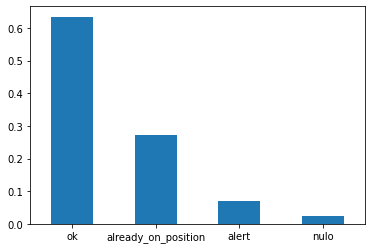

In [22]:
dataset['laudo_new'].value_counts(normalize=True).plot(kind='bar')
plt.xticks(rotation=0)
plt.show();

## Extraindo as variávais <i>command_open</i> e <i>command_close</i> a partir da coluna <i>descrição</i>

Variável para indicar se o comando foi para abrir ou fechar a válvula (1 - sim, 0 não)

In [23]:
position_df = dataset.filter(["sigValvePosition", "descrição"])

In [24]:
position_group = position_df.groupby(by="descrição")

In [25]:
for key, item in position_group:
    print(position_group.get_group(key), "\n\n")

       sigValvePosition        descrição
1                     0  Cur. Close Flow
7                     0  Cur. Close Flow
10                    0  Cur. Close Flow
13                    0  Cur. Close Flow
19                    0  Cur. Close Flow
...                 ...              ...
19101                 0  Cur. Close Flow
19107                 0  Cur. Close Flow
19110                 0  Cur. Close Flow
19113                 0  Cur. Close Flow
19119                 0  Cur. Close Flow

[2942 rows x 2 columns] 


       sigValvePosition                          descrição
0                     0  Cur. Close Pressure Function Line
6                     0  Cur. Close Pressure Function Line
9                     0  Cur. Close Pressure Function Line
12                    0  Cur. Close Pressure Function Line
18                    0  Cur. Close Pressure Function Line
...                 ...                                ...
19102                 0  Cur. Close Pressure Function Line
19108   

In [26]:
command_close = []
command_open = []

In [27]:
for row in dataset['descrição']:
  if 'Close' in row:
    command_close.append(1)
  else:
    command_close.append(0)
  if 'Open' in row:
    command_open.append(1)
  else:
    command_open.append(0)

In [28]:
command_close[:15]

[1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [29]:
command_open[:15]

[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Inserindo as váriaveis de comando no dataset

In [30]:
dataset.insert(loc=8, column='command_close', value=command_close)

In [31]:
dataset.insert(loc=9, column='command_open', value=command_open)

In [32]:
dataset.head(2)

,poco_id,poco_nome,valvula_id,valvula_nome,id,cod,descrição,sigValvePosition,command_close,command_open,sigDate,sigTime,sigData1,sigData2,sigData3,sigData4,sigData5,sigData6,sigData7,sigData8,sigData9,sigData10,sigData11,sigData12,sigData13,sigData14,sigData15,sigData16,sigData17,sigData18,sigData19,sigData20,sigData21,sigData22,sigData23,sigData24,sigData25,sigData26,sigData27,sigData28,...,sigData83,sigData84,sigData85,sigData86,sigData87,sigData88,sigData89,sigData90,sigData91,sigData92,sigData93,sigData94,sigData95,sigData96,sigData97,sigData98,sigData99,sigData100,sigData101,sigData102,sigData103,sigData104,sigData105,sigData106,sigData107,sigData108,sigData109,sigData110,sigData111,sigData112,sigData113,sigData114,sigData115,sigData116,sigData117,sigData118,sigData119,sigData120,Laudo,laudo_new
0,Well 1,?,PMV-1210218A,Production Master Valve 2 [M2],3,6003,Cur. Close Pressure Function Line,0,1,0,20090914 17:46,60,"-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771",...,"1273,069611","1190,133545","1107,197273","1028,407997","953,7655106","883,2698135","812,7740479","746,425209","684,2230911","626,1677628","568,1124687","514,2039986","464,442318","414,6806374","369,0657806","327,5977135","286,1296463","248,8083858","215,6339493","182,4594784","153,4318485","124,4041929","99,52336121","78,78931904","58,05528975","41,46806717","29,02764487","16,58722579","8,293612897","4,146806449",0,0,0,0,0,0,0,0,NaN,nulo
1,Well 1,?,PMV-1210218A,Production Master Valve 2 [M2],3,8003,Cur. Close Flow,0,1,0,20090914 17:46,60,0,"0,002573282","0,005188067","0,008549935","0,01224384","0,016269779","0,020461738","0,024819717","0,029302206","0,033826202","0,038391698","0,043040209","0,047605705","0,052212711","0,056778211","0,061260704","0,065701686","0,070101164","0,074417643","0,078692608","0,082884565","0,087076522","0,091226973","0,095377438","0,099527888","0,103678338","0,107828788","0,111979254",...,"0,340254217","0,344404697","0,348555118","0,352705598","0,356856018","0,361006498","0,365156919","0,369307399","0,373457879","0,377608299","0,381758779","0,3859092","0,39005968","0,394168586","0,398194551","0,40188846","0,405125827","0,407823622","0,409898818","0,411434501","0,412555128","0,413343728","0,413883269","0,414256811","0,414505839","0,414630353","0,414754868","0,414796352","0,414837867","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382",NaN,nulo


In [33]:
dataset.command_close.sum()

8826

In [34]:
dataset.command_open.sum()

10338

## Análise temporal dos comandos de acionamento

Convertendo a variável <i>sigDate</i> de string para data.

In [35]:
type(dataset['sigDate'][0])
dataset['sigDate'][0]

'20090914 17:46'

In [36]:
date, time = dataset['sigDate'][0].split(' ') 

In [37]:
print('Data: {} e Hora: {}'.format(date, time))

Data: 20090914 e Hora: 17:46


In [38]:
date_obj = datetime.strptime(date, '%Y%m%d').date()

In [39]:
print(date_obj)

2009-09-14


In [40]:
time_obj = datetime.strptime(time, '%H:%M').time()

In [41]:
print(time_obj)

17:46:00


In [42]:
date_list = []
time_list = []

In [43]:
for row in dataset['sigDate']:
  date, time = row.split(' ')
  date_list.append(datetime.strptime(date, '%Y%m%d').date())
  time_list.append(datetime.strptime(time, '%H:%M').time())

Inserindo Date e Hora no dataset original

In [44]:
dataset.insert(loc=11, column='date', value=date_list)
dataset.insert(loc=12, column='time', value=time_list)

In [45]:
dataset.head(2)

,poco_id,poco_nome,valvula_id,valvula_nome,id,cod,descrição,sigValvePosition,command_close,command_open,sigDate,date,time,sigTime,sigData1,sigData2,sigData3,sigData4,sigData5,sigData6,sigData7,sigData8,sigData9,sigData10,sigData11,sigData12,sigData13,sigData14,sigData15,sigData16,sigData17,sigData18,sigData19,sigData20,sigData21,sigData22,sigData23,sigData24,sigData25,sigData26,...,sigData83,sigData84,sigData85,sigData86,sigData87,sigData88,sigData89,sigData90,sigData91,sigData92,sigData93,sigData94,sigData95,sigData96,sigData97,sigData98,sigData99,sigData100,sigData101,sigData102,sigData103,sigData104,sigData105,sigData106,sigData107,sigData108,sigData109,sigData110,sigData111,sigData112,sigData113,sigData114,sigData115,sigData116,sigData117,sigData118,sigData119,sigData120,Laudo,laudo_new
0,Well 1,?,PMV-1210218A,Production Master Valve 2 [M2],3,6003,Cur. Close Pressure Function Line,0,1,0,20090914 17:46,2009-09-14,17:46:00,60,"-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771",...,"1273,069611","1190,133545","1107,197273","1028,407997","953,7655106","883,2698135","812,7740479","746,425209","684,2230911","626,1677628","568,1124687","514,2039986","464,442318","414,6806374","369,0657806","327,5977135","286,1296463","248,8083858","215,6339493","182,4594784","153,4318485","124,4041929","99,52336121","78,78931904","58,05528975","41,46806717","29,02764487","16,58722579","8,293612897","4,146806449",0,0,0,0,0,0,0,0,NaN,nulo
1,Well 1,?,PMV-1210218A,Production Master Valve 2 [M2],3,8003,Cur. Close Flow,0,1,0,20090914 17:46,2009-09-14,17:46:00,60,0,"0,002573282","0,005188067","0,008549935","0,01224384","0,016269779","0,020461738","0,024819717","0,029302206","0,033826202","0,038391698","0,043040209","0,047605705","0,052212711","0,056778211","0,061260704","0,065701686","0,070101164","0,074417643","0,078692608","0,082884565","0,087076522","0,091226973","0,095377438","0,099527888","0,103678338",...,"0,340254217","0,344404697","0,348555118","0,352705598","0,356856018","0,361006498","0,365156919","0,369307399","0,373457879","0,377608299","0,381758779","0,3859092","0,39005968","0,394168586","0,398194551","0,40188846","0,405125827","0,407823622","0,409898818","0,411434501","0,412555128","0,413343728","0,413883269","0,414256811","0,414505839","0,414630353","0,414754868","0,414796352","0,414837867","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382",NaN,nulo


In [46]:
def f(i):
  l = ["Segunda", "Terça", "Quarta", "Quinta", "Sexta", "Sábado", "Domingo"]
  return l[i];

In [47]:
day_df=pd.DataFrame(dataset["descrição"])

In [48]:
day_list = []
for row in dataset['date']:
  day_list.append(row.weekday())

In [49]:
day_df['day_of_date'] = day_list
day_df['day_of_date_n'] = day_list
day_df['day_of_date'] = day_df['day_of_date'].apply(f)
day_df["commandcount"] = 1
day = day_df.groupby(["day_of_date", "day_of_date_n"]).sum()
day.reset_index(inplace=True)

In [50]:
day.sort_values(by=['day_of_date_n'], inplace=True)

In [51]:
day['commandcount']=day['commandcount'].apply(lambda x: int(x/3))

In [52]:
display(day)

,day_of_date,day_of_date_n,commandcount
3,Segunda,0,731
6,Terça,1,809
1,Quarta,2,822
2,Quinta,3,971
4,Sexta,4,1221
5,Sábado,5,992
0,Domingo,6,842


In [53]:
fig = px.line_polar(day, r='commandcount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=False
)
fig.show()

In [54]:
a = 100*day_df['day_of_date'].value_counts(normalize=True)

In [55]:
display(pd.DataFrame(a))

,day_of_date
Sexta,19.113964
Sábado,15.529117
Quinta,15.200376
Domingo,13.180964
Quarta,12.867877
Terça,12.664371
Segunda,11.443331


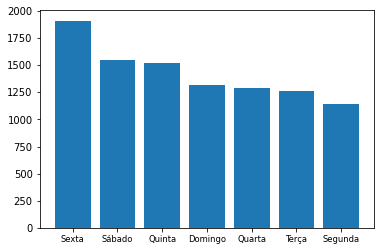

In [56]:
plt.bar(range(len(a)), 100*(a.values), align='center')
plt.xticks(range(len(a)), a.index.values, size='small')
plt.show()

Por mês e ano

In [57]:
year_list = []
month_list = []
for row in dataset['date']:
  year_list.append(row.year)
  month_list.append(row.month)

day_df['ano'] = year_list
day_df['mes'] = month_list

In [58]:
day_df.head()

,descrição,day_of_date,day_of_date_n,commandcount,ano,mes
0,Cur. Close Pressure Function Line,Segunda,0,1,2009,9
1,Cur. Close Flow,Segunda,0,1,2009,9
2,Cur. Close Pressure Returne Line,Segunda,0,1,2009,9
3,Cur. Open Pressure Function Line,Segunda,0,1,2009,9
4,Cur. Open Flow,Segunda,0,1,2009,9


In [59]:
def mes_nome(i):
  l = ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"]
  return l[i-1];

In [60]:
day_df['mes_nome'] = day_df['mes'].apply(mes_nome)

In [61]:
month = day_df.groupby(["mes_nome", 'mes']).sum()
month.reset_index(inplace=True)

In [62]:
month.sort_values(by=['mes'], inplace=True)

In [63]:
month['commandcount']=month['commandcount'].apply(lambda x: int(x/3))

In [64]:
display(month)

,mes_nome,mes,day_of_date_n,commandcount,ano
4,Jan,1,3297,327,1977357
3,Fev,2,5922,578,3494442
8,Mar,3,7017,721,4360257
0,Abr,4,5832,656,3967152
7,Mai,5,6480,667,4032867
6,Jun,6,4125,422,2551503
5,Jul,7,7815,825,4988760
1,Ago,8,4812,495,2992098
11,Set,9,2520,346,2090880
10,Out,10,4239,434,2624187


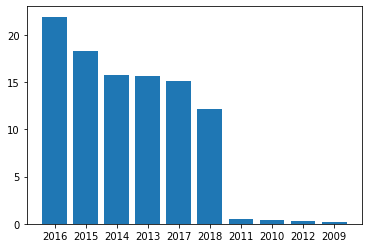

In [65]:
a = month.loc[:,['mes_nome','commandcount']]

a = day_df['ano'].value_counts(normalize=True)

plt.bar(range(len(a)), 100*(a.values), align='center')
plt.xticks(range(len(a)), a.index.values, size='medium')
plt.show()

In [66]:
a = 100*day_df['mes_nome'].value_counts(normalize=True)

In [67]:
display(pd.DataFrame(a))

,mes_nome
Jul,12.914840
Mar,11.286788
Mai,10.441453
Abr,10.269255
Fev,9.048215
Nov,8.876018
Ago,7.748904
Out,6.793989
Jun,6.606137
Dez,5.479023


In [68]:
#display(a2)

In [69]:
fig = px.line_polar(month, r='commandcount', theta='mes_nome', line_close=True)
fig.update_traces(fill='toself')
#fig.update_layout(polar=dict(radialaxis=dict(visible=True,)),showlegend=False)
fig.show()

In [70]:
day_df.head(3)

,descrição,day_of_date,day_of_date_n,commandcount,ano,mes,mes_nome
0,Cur. Close Pressure Function Line,Segunda,0,1,2009,9,Set
1,Cur. Close Flow,Segunda,0,1,2009,9,Set
2,Cur. Close Pressure Returne Line,Segunda,0,1,2009,9,Set


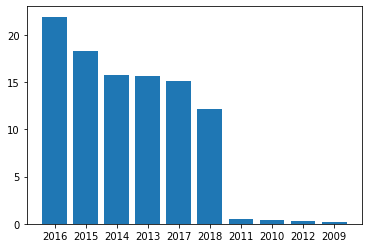

In [71]:
a = day_df['ano'].value_counts(normalize=True)

plt.bar(range(len(a)), 100*(a.values), align='center')
plt.xticks(range(len(a)), a.index.values, size='medium')
plt.show()

Avaliando a variável sigTime

In [72]:
dataset['sigTime'].value_counts()

120    7947
60     6885
80     2202
40     1653
100     243
300      42
90       33
30       21
200      21
10       18
15       18
20       15
250      12
9         9
27        9
8         9
5         9
7         6
11        3
29        3
4         3
3         3
Name: sigTime, dtype: int64

In [73]:
dataset['valvula_nome'].unique()

array(['Production Master Valve 2 [M2]', 'Production Wing Valve 2 [W2]',
       'Monoethilene Glycol Injection Valve 1 [VMEG1]',
       'Production Wing Valve 1 [W1]',
       'Monoethilene Glycol Injection Valve 2 [VMEG2]',
       'Cross Over Valve [XO]', 'Production Master Valve 1 [M1]',
       '[M-XO]', '[M]', '[G2]', '[G1-XO]', '[G2-XO]', '[G1]'],
      dtype=object)

In [74]:
dataset['poco_nome'].unique()

array(['?', 'MPG 1', 'MPG 7', 'MPG 8', 'MPG 2', 'MXL 2', 'MPG 6', 'MPG 5',
       'MPG 4', 'MPG 3', 'MXL 7', 'MXL 9', 'MXL 13', 'MXL 11', 'MXL 17',
       'MXL 18'], dtype=object)

## Quantidade de comandos de acionamento enviado por tipo de válvula

Avaliando os comandos por cada tipo de válvula

In [75]:
valve_type_df = dataset.filter(['poco_nome', 'valvula_id', 'valvula_nome'])

In [76]:
valve_type_df['commandcount'] = 1

In [77]:
valve_type_df.head(3)

,poco_nome,valvula_id,valvula_nome,commandcount
0,?,PMV-1210218A,Production Master Valve 2 [M2],1
1,?,PMV-1210218A,Production Master Valve 2 [M2],1
2,?,PMV-1210218A,Production Master Valve 2 [M2],1


Obtendo o nome reduzido das válvulas

In [78]:
def get_valve_name(s):
  s=s.split("[")
  s=s[1]
  s=s[:-1]
  return s

In [79]:
valve_type_df['valvula_nome']=valve_type_df['valvula_nome'].apply(get_valve_name)

Criando dataframe para contar as atuações por poço e válvula

In [80]:
valve_well_count = valve_type_df.groupby(['poco_nome', 'valvula_nome']).sum()

In [81]:
valve_well_count['commandcount']=valve_well_count['commandcount'].apply(lambda x: int(x/3))

In [82]:
display(valve_well_count)

commandcount
poco_nome valvula_nome              
?         M1                       8
          M2                       6
          VMEG1                    6
          VMEG2                    6
          W1                       8
...                              ...
MXL 9     VMEG1                   38
          VMEG2                   71
          W1                     158
          W2                      17
          XO                      21

[80 rows x 1 columns]

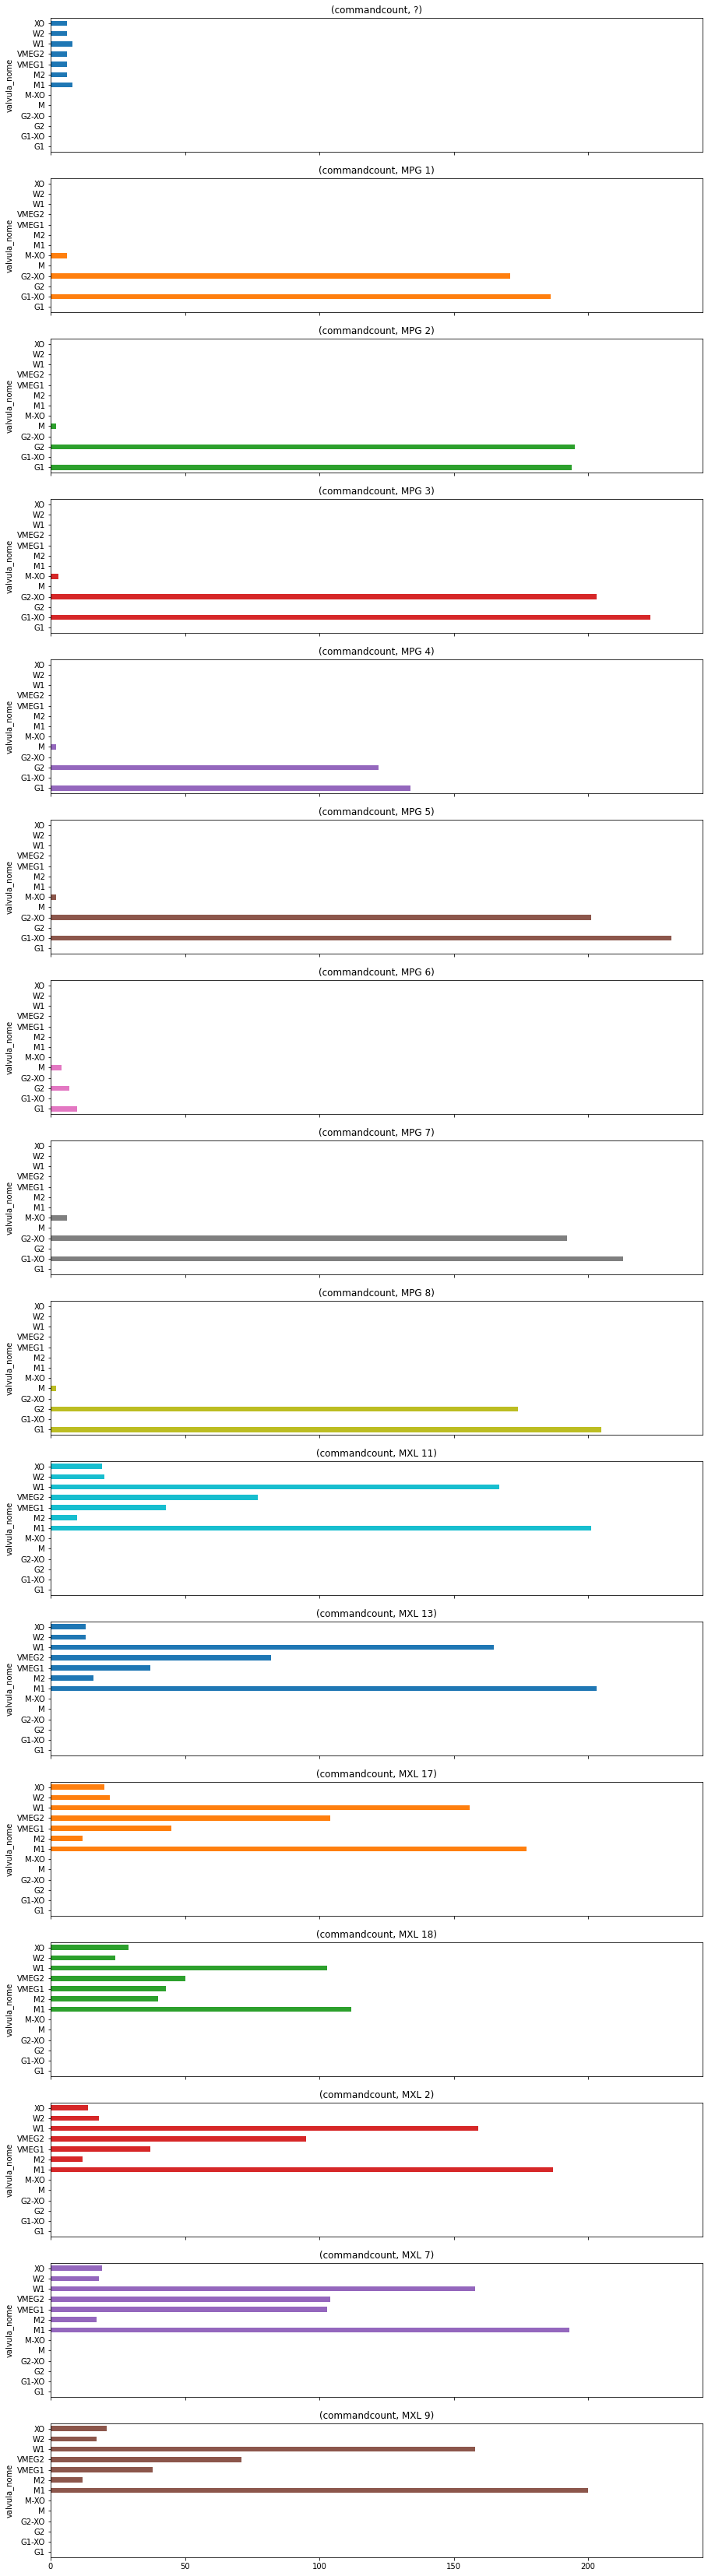

In [83]:
ax = valve_well_count.unstack(level=0).plot(kind='barh', subplots=True, figsize=(15, 60), legend=False);

Contagem por tipo de válvula

In [84]:
valve_type_count = valve_type_df.groupby(['valvula_nome']).sum()

In [85]:
valve_type_count['commandcount']=valve_type_count['commandcount'].apply(lambda x: int(x/3))

In [86]:
valve_type_count.sort_values(by=['commandcount'], ascending=False, inplace=True)

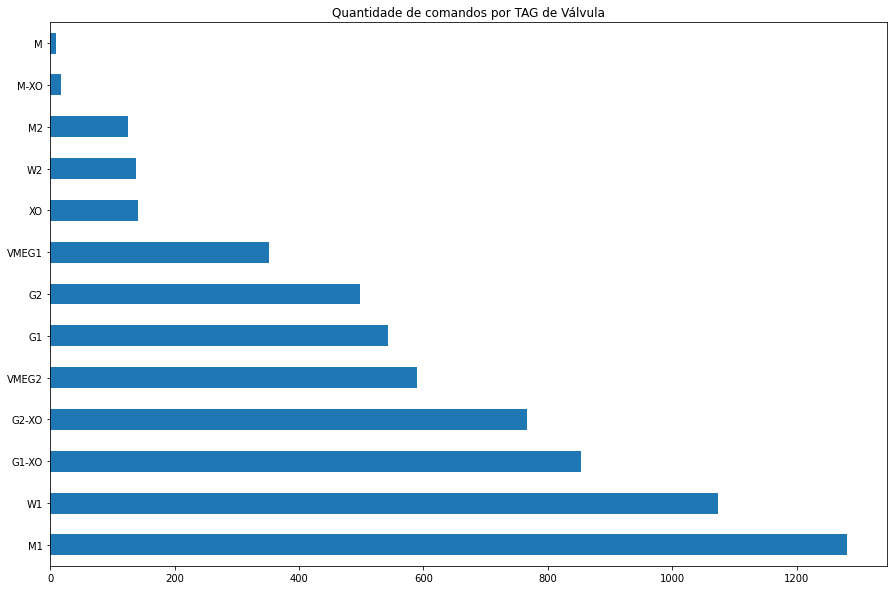

In [87]:
ax = valve_type_count.plot.barh(figsize=(15, 10), legend=False, title='Quantidade de comandos por TAG de Válvula');
ax.set_ylabel("");

In [88]:
valve_id_count = valve_type_df.filter(['valvula_id', 'commandcount']).groupby('valvula_id').sum()

In [89]:
valve_id_count['commandcount']=valve_id_count['commandcount'].apply(lambda x: int(x/3))

In [90]:
valve_id_count.sort_values(by=['commandcount'], ascending=False, inplace=True)

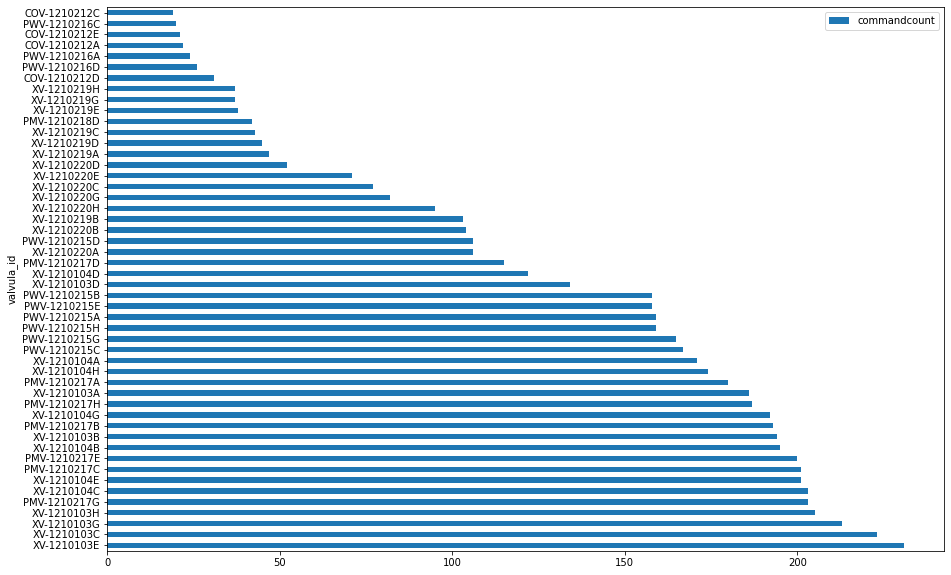

In [91]:
#plt.figure(figsize=(10, 10))
valve_id_count.head(50).plot.barh(figsize=(15, 10));

Transformar o tipo de válvula numa variável categórica para ser utilizada no modelo: ,  

*   M1, W1, G1, M, M-XO G1-XO, G2 e G2-XO são de 5 1/8"
*   M2, W2 e XO são de 2 1/16" 
*   VMEG1 e VMEG2 são de 1"

In [92]:
V5 = ['M1', 'W1', 'G1', 'G1-XO', 'G2', 'G2-XO', 'M', 'M-XO']
V2 = ['M2', 'W2', 'XO'] 
V1 = ['VMEG1', 'VMEG2']

In [93]:
dataset.head(3)

,poco_id,poco_nome,valvula_id,valvula_nome,id,cod,descrição,sigValvePosition,command_close,command_open,sigDate,date,time,sigTime,sigData1,sigData2,sigData3,sigData4,sigData5,sigData6,sigData7,sigData8,sigData9,sigData10,sigData11,sigData12,sigData13,sigData14,sigData15,sigData16,sigData17,sigData18,sigData19,sigData20,sigData21,sigData22,sigData23,sigData24,sigData25,sigData26,...,sigData83,sigData84,sigData85,sigData86,sigData87,sigData88,sigData89,sigData90,sigData91,sigData92,sigData93,sigData94,sigData95,sigData96,sigData97,sigData98,sigData99,sigData100,sigData101,sigData102,sigData103,sigData104,sigData105,sigData106,sigData107,sigData108,sigData109,sigData110,sigData111,sigData112,sigData113,sigData114,sigData115,sigData116,sigData117,sigData118,sigData119,sigData120,Laudo,laudo_new
0,Well 1,?,PMV-1210218A,Production Master Valve 2 [M2],3,6003,Cur. Close Pressure Function Line,0,1,0,20090914 17:46,2009-09-14,17:46:00,60,"-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771",...,"1273,069611","1190,133545","1107,197273","1028,407997","953,7655106","883,2698135","812,7740479","746,425209","684,2230911","626,1677628","568,1124687","514,2039986","464,442318","414,6806374","369,0657806","327,5977135","286,1296463","248,8083858","215,6339493","182,4594784","153,4318485","124,4041929","99,52336121","78,78931904","58,05528975","41,46806717","29,02764487","16,58722579","8,293612897","4,146806449",0,0,0,0,0,0,0,0,NaN,nulo
1,Well 1,?,PMV-1210218A,Production Master Valve 2 [M2],3,8003,Cur. Close Flow,0,1,0,20090914 17:46,2009-09-14,17:46:00,60,0,"0,002573282","0,005188067","0,008549935","0,01224384","0,016269779","0,020461738","0,024819717","0,029302206","0,033826202","0,038391698","0,043040209","0,047605705","0,052212711","0,056778211","0,061260704","0,065701686","0,070101164","0,074417643","0,078692608","0,082884565","0,087076522","0,091226973","0,095377438","0,099527888","0,103678338",...,"0,340254217","0,344404697","0,348555118","0,352705598","0,356856018","0,361006498","0,365156919","0,369307399","0,373457879","0,377608299","0,381758779","0,3859092","0,39005968","0,394168586","0,398194551","0,40188846","0,405125827","0,407823622","0,409898818","0,411434501","0,412555128","0,413343728","0,413883269","0,414256811","0,414505839","0,414630353","0,414754868","0,414796352","0,414837867","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382",NaN,nulo
2,Well 1,?,PMV-1210218A,Production Master Valve 2 [M2],3,16003,Cur. Close Pressure Returne Line,0,1,0,20090914 17:46,2009-09-14,17:46:00,60,"2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","4,146806717","6,911344528","9,675881624","13,82268906","19,35176325","26,26310635","34,55671978","42,85033321","53,9084816","66,34890747","80,17159653",...,"60,81982613","51,14394951","41,46806431","33,17445374","26,26310635","19,35176325","13,82268906","9,675881624","5,529075265","2,764537632","1,382268816",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,nulo


In [94]:
dataset['poco_id'].value_counts()

MPG 8-7    2376
MPG 1-2    2262
MPG 3-4    2061
Well 2     1836
Well 1     1656
Well 3     1611
Well 7     1587
Well 8     1566
Well 5     1551
MPG 6-5    1365
Well 4     1251
Well 6       42
Name: poco_id, dtype: int64

In [95]:
dataset['poco_nome'].value_counts()

MXL 7     1836
MXL 11    1611
MXL 17    1608
MXL 13    1587
MXL 2     1566
MXL 9     1551
MPG 5     1302
MPG 3     1287
MPG 7     1233
MXL 18    1203
MPG 2     1173
MPG 8     1143
MPG 1     1089
MPG 4      774
?          138
MPG 6       63
Name: poco_nome, dtype: int64

## Tratando os dados numéricos

Copiados os dados

In [96]:
df_data = dataset.loc[:,'sigData1':'sigData120']

In [97]:
df_data.head(15)

,sigData1,sigData2,sigData3,sigData4,sigData5,sigData6,sigData7,sigData8,sigData9,sigData10,sigData11,sigData12,sigData13,sigData14,sigData15,sigData16,sigData17,sigData18,sigData19,sigData20,sigData21,sigData22,sigData23,sigData24,sigData25,sigData26,sigData27,sigData28,sigData29,sigData30,sigData31,sigData32,sigData33,sigData34,sigData35,sigData36,sigData37,sigData38,sigData39,sigData40,...,sigData81,sigData82,sigData83,sigData84,sigData85,sigData86,sigData87,sigData88,sigData89,sigData90,sigData91,sigData92,sigData93,sigData94,sigData95,sigData96,sigData97,sigData98,sigData99,sigData100,sigData101,sigData102,sigData103,sigData104,sigData105,sigData106,sigData107,sigData108,sigData109,sigData110,sigData111,sigData112,sigData113,sigData114,sigData115,sigData116,sigData117,sigData118,sigData119,sigData120
0,"-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","8007,483582","7870,638428","7729,647034","7588,65564","7443,518005","7298,379822","7149,094299",...,"1451,382248","1360,152466","1273,069611","1190,133545","1107,197273","1028,407997","953,7655106","883,2698135","812,7740479","746,425209","684,2230911","626,1677628","568,1124687","514,2039986","464,442318","414,6806374","369,0657806","327,5977135","286,1296463","248,8083858","215,6339493","182,4594784","153,4318485","124,4041929","99,52336121","78,78931904","58,05528975","41,46806717","29,02764487","16,58722579","8,293612897","4,146806449",0,0,0,0,0,0,0,0
1,0,"0,002573282","0,005188067","0,008549935","0,01224384","0,016269779","0,020461738","0,024819717","0,029302206","0,033826202","0,038391698","0,043040209","0,047605705","0,052212711","0,056778211","0,061260704","0,065701686","0,070101164","0,074417643","0,078692608","0,082884565","0,087076522","0,091226973","0,095377438","0,099527888","0,103678338","0,107828788","0,111979254","0,116129704","0,120280154","0,124430604","0,128581062","0,132731527","0,136881977","0,141032428","0,145182878","0,149333343","0,153483793","0,157634243","0,161784694",...,"0,331953317","0,336103767","0,340254217","0,344404697","0,348555118","0,352705598","0,356856018","0,361006498","0,365156919","0,369307399","0,373457879","0,377608299","0,381758779","0,3859092","0,39005968","0,394168586","0,398194551","0,40188846","0,405125827","0,407823622","0,409898818","0,411434501","0,412555128","0,413343728","0,413883269","0,414256811","0,414505839","0,414630353","0,414754868","0,414796352","0,414837867","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382"
2,"2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","4,146806717","6,911344528","9,675881624","13,82268906","19,35176325","26,26310635","34,55671978","42,85033321","53,9084816","66,34890747","80,17159653","96,75882339","114,7283134","134,0800781","154,814106","178,3126831","203,193512","229,4566269","257,102005","286,1296463","316,5395508","346,9494781","378,7416458","409,1515961","439,5614777",...,"84,31840324","71,87798309","60,81982613","51,14394951","41,46806431","33,17445374","26,26310635","19,35176325","13,82268906","9,675881624","5,529075265","2,764537632","1,382268816",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-32

In [98]:
dataset['descrição'].unique()

array(['Cur. Close Pressure Function Line', 'Cur. Close Flow',
       'Cur. Close Pressure Returne Line',
       'Cur. Open Pressure Function Line', 'Cur. Open Flow',
       'Cur. Open Pressure Supply Line'], dtype=object)

In [99]:
df_data.iloc[0,:]

sigData1      -3259,389771
sigData2      -3259,389771
sigData3      -3259,389771
sigData4      -3259,389771
sigData5      -3259,389771
                  ...     
sigData116               0
sigData117               0
sigData118               0
sigData119               0
sigData120               0
Name: 0, Length: 120, dtype: object

Separandos os dados números em três conjustos: pressão de função, fluxo e pressão de retorno/suprimento

In [100]:
df_pressure_function = dataset.iloc[range(0,len(dataset),3),14:134]

In [101]:
df_flow = dataset.iloc[range(1,len(dataset),3),14:134]
df_return_supply = dataset.iloc[range(2,len(dataset),3),14:134]

In [102]:
df_flow.tail(15)

,sigData1,sigData2,sigData3,sigData4,sigData5,sigData6,sigData7,sigData8,sigData9,sigData10,sigData11,sigData12,sigData13,sigData14,sigData15,sigData16,sigData17,sigData18,sigData19,sigData20,sigData21,sigData22,sigData23,sigData24,sigData25,sigData26,sigData27,sigData28,sigData29,sigData30,sigData31,sigData32,sigData33,sigData34,sigData35,sigData36,sigData37,sigData38,sigData39,sigData40,...,sigData81,sigData82,sigData83,sigData84,sigData85,sigData86,sigData87,sigData88,sigData89,sigData90,sigData91,sigData92,sigData93,sigData94,sigData95,sigData96,sigData97,sigData98,sigData99,sigData100,sigData101,sigData102,sigData103,sigData104,sigData105,sigData106,sigData107,sigData108,sigData109,sigData110,sigData111,sigData112,sigData113,sigData114,sigData115,sigData116,sigData117,sigData118,sigData119,sigData120
19120,"3358,91333","1318,684448","1310,390869","1297,950439","1277,216431","1273,06958","1252,335571","1239,895142","1219,161133","1206,720703","1202,573853","866,6825562","829,3612671","829,3612671","829,3612671","825,2145386","825,2145386","825,2145386","825,2145386","825,2145386","825,2145386","825,2145386","825,2145386","821,067627","821,067627","821,067627","821,067627","821,067627","821,067627","821,067627","821,067627","821,067627","816,9208984","816,9208984","816,9208984","816,9208984","816,9208984","816,9208984","816,9208984","816,9208984",...,"746,4251709","746,4251709","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","742,2783813","738,1315308","742,2783813","738,1315308","738,1315308","738,1315308","738,1315308","738,1315308","738,1315308","738,1315308","738,1315308"
19123,"763,0123901","2873,736816","2869,590088","2865,443359","2840,5625","2819,828369","2803,241211","2790,800781","2774,213379","2765,919922","2741,039063","2741,039063","2728,598877","2728,598877","2707,864746","2695,424316","2687,130615","2678,836914","2662,249756","2666,396484","2674,690186","2662,249756","2658,102783","2649,809326","2645,662354","2629,075195","2624,928467","2616,634766","2608,341309","2604,194336","2600,047607","2587,607178","2579,313721","2575,166748","2566,873291","2566,873291","2645,662354","2819,828369","2828,12207","2832,268799",...,"3043,756104","3043,756104","3047,902832","3052,049561","3056,196533","3060,343018","3060,343018","3064,48999","3068,636719","3068,636719","3072,783447","3076,93042","3081,077148","3085,224121","3085,224121","3089,37085","3093,517578","3093,517578","3097,664551","3101,811279","3101,811279","3105,958008","3105,958008","3110,10498","3114,251709","3118,398438","3118,398438","3122,545166","3126,692139","3126,692139","3130,838867","3130,838867","3134,985596","3139,132568","3139,132568","3143,279297","3147,426025","3147,426025","3151,572998","3151,572998"
19126,"638,6082153","2575,166748","2562,726318","2558,57959","2546,13916","2525,405273","2508,817871","2508,817871","2500,52417","2483,937256","2475,643555","2463,203125","2463,203125","2446,615723","2450,762695","2438,322266","2421,735107","2421,735107","2405,147705","2409,294678","2384,413818","2388,560547","2376,120117","2367,82666","2363,679688","2359,532715","2347,092529","2342,945557","2334,6521","2334,6521","2318,064697","2318,064697","2313,917969","2305,624512","2297,330811","2301,477539","2405,147705","2541,992432","2550,285889","2558,57959",...,"2786,653809","2790,800781","2794,94751","2799,094482","2803,241211","2803,241211","2807,387939","2811,534912","2815,681396","2819,828369","2823,975342","2828,12207","2832,268799","2836,415527","2840,5625","2840,5625","2844,709229","2848,855957","2853,00293","2857,149658","2857,149658","2861,296387","2865,443359","2869,590088","2873,736816","2873,736816","2877,883789","2882,030

In [103]:
df_return_supply.tail(15)

,sigData1,sigData2,sigData3,sigData4,sigData5,sigData6,sigData7,sigData8,sigData9,sigData10,sigData11,sigData12,sigData13,sigData14,sigData15,sigData16,sigData17,sigData18,sigData19,sigData20,sigData21,sigData22,sigData23,sigData24,sigData25,sigData26,sigData27,sigData28,sigData29,sigData30,sigData31,sigData32,sigData33,sigData34,sigData35,sigData36,sigData37,sigData38,sigData39,sigData40,...,sigData81,sigData82,sigData83,sigData84,sigData85,sigData86,sigData87,sigData88,sigData89,sigData90,sigData91,sigData92,sigData93,sigData94,sigData95,sigData96,sigData97,sigData98,sigData99,sigData100,sigData101,sigData102,sigData103,sigData104,sigData105,sigData106,sigData107,sigData108,sigData109,sigData110,sigData111,sigData112,sigData113,sigData114,sigData115,sigData116,sigData117,sigData118,sigData119,sigData120
19121,"823,8322144","982,7931519","980,0286255","974,4995117","971,7349243","968,970459","964,8236694","948,2363892","945,4718628","941,3250732","937,1782837","851,4776001","819,6853638","819,6853638","819,6853638","818,3031616","818,3031616","816,9208984","816,9208984","816,9208984","815,5385742","815,5385742","814,156311","814,156311","814,156311","814,156311","812,7741089","812,7741089","812,7741089","811,3917847","811,3917847","811,3917847","810,0095215","810,0095215","810,0095215","808,6272583","808,6272583","808,6272583","808,6272583","807,2449951",...,"738,1315308","738,1315308","738,1315308","738,1315308","738,1315308","736,7493286","736,7493286","736,7493286","736,7493286","736,7493286","736,7493286","736,7493286","735,3670044","735,3670044","735,3670044","735,3670044","735,3670044","735,3670044","735,3670044","735,3670044","735,3670044","735,3670044","733,9847412","733,9847412","733,9847412","733,9847412","733,9847412","733,9847412","733,9847412","733,9847412","733,9847412","733,9847412","733,9847412","733,9847412","733,9847412","732,602478","733,9847412","732,602478","732,602478","732,602478"
19124,"3376,421875","3077,852051","3059,421631","3037,30542","3011,50293","2982,014404","2959,898193","2941,467773","2923,037842","2904,607666","2886,177246","2871,433105","2856,688965","2841,944824","2827,200439","2812,456299","2797,712158","2782,967773","2768,223877","2757,165527","2749,793457","2746,107422","2731,363037","2723,991211","2712,932861","2701,874756","2694,502686","2679,758545","2672,386475","2661,328369","2650,27002","2642,897949","2631,839844","2624,467773","2617,095459","2606,037354","2642,897949","2749,793457","2757,165527","2764,537598",...,"2974,642578","2974,642578","2982,014404","2982,014404","2985,700684","2989,386719","2993,07251","2993,07251","2996,758789","3000,444824","3004,131104","3007,816895","3011,50293","3015,189209","3015,189209","3018,875244","3022,561035","3026,247314","3029,93335","3029,93335","3033,619141","3037,30542","3040,991455","3040,991455","3044,677246","3048,363525","3048,363525","3052,049561","3055,73584","3059,421631","3059,421631","3063,107666","3066,793945","3066,793945","3070,479736","3074,165771","3077,852051","3077,852051","3081,538086","3085,223877"
19127,"3203,177734","2900,921631","2871,433105","2856,688965","2834,57251","2805,084229","2786,653809","2764,537598","2749,793457","2735,049316","2720,304932","2705,561035","2690,81665","2679,758545","2665,014404","2650,27002","2639,211914","2628,153809","2613,409668","2602,351563","2594,979248","2583,921143","2569,177002","2558,118896","2550,746826","2539,688721","2528,630371","2521,258301","2510,200195","2506,51416","2495,456055","2484,397949","2480,71167","2473,339844","2462,281494","2458,595459","2495,456055","2594,979248","2602,351563","2609,723633",...,"2838,258545","2841,944824","2845,630859","2849,31665","2853,00293","2856,688965","2864,061035","2864,061035","2867,74707","2875,119141","2875,119141","2882,491211","2882,491211","2886,177246","2889,863281","2893,549561","2897,235352","2900,921631","2904,607666","2908,293457","2911,979736","2911,979736","2919,351563","2919,351563","2923,037842","2926,723877","2930,409668","2

In [104]:
df_pressure_function.tail(15)

,sigData1,sigData2,sigData3,sigData4,sigData5,sigData6,sigData7,sigData8,sigData9,sigData10,sigData11,sigData12,sigData13,sigData14,sigData15,sigData16,sigData17,sigData18,sigData19,sigData20,sigData21,sigData22,sigData23,sigData24,sigData25,sigData26,sigData27,sigData28,sigData29,sigData30,sigData31,sigData32,sigData33,sigData34,sigData35,sigData36,sigData37,sigData38,sigData39,sigData40,...,sigData81,sigData82,sigData83,sigData84,sigData85,sigData86,sigData87,sigData88,sigData89,sigData90,sigData91,sigData92,sigData93,sigData94,sigData95,sigData96,sigData97,sigData98,sigData99,sigData100,sigData101,sigData102,sigData103,sigData104,sigData105,sigData106,sigData107,sigData108,sigData109,sigData110,sigData111,sigData112,sigData113,sigData114,sigData115,sigData116,sigData117,sigData118,sigData119,sigData120
19119,0,"0,02220493","0,045945525","0,069437094","0,093136184","0,116171211","0,139496759","0,162822306","0,185483798","0,207771719","0,22976914","0,251808047","0,262806743","0,273556411","0,284015566","0,294391721","0,304933876","0,315309972","0,324150443","0,335315168","0,345608294","0,355652422","0,365821034","0,375865132","0,385743171","0,395787299","0,405374855","0,415086895","0,424632967","0,434303522","0,444015563","0,45335409","0,463024646","0,472114146","0,481577158","0,490915716","0,499880672","0,509260714","0,518433213","0,527481198",...,"0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449","0,689639449"
19122,0,"0,020669261","0,065328144","0,110319063","0,153566793","0,197022051","0,237239957","0,28131777","0,321992218","0,362957209","0,403341115","0,442811936","0,481826186","0,520425439","0,558443546","0,596835315","0,633691311","0,670879424","0,706822336","0,743097305","0,777919531","0,812119365","0,845239937","0,878111541","0,910734057","0,943149209","0,975149214","1,006817222","1,03777945","1,068824887","1,09974575","1,129836559","1,159927368","1,18960309","1,219029784","1,248332024","1,277053118","1,281535625","1,281535625","1,281535625",...,"1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625","1,281535625"
19125,0,"0,02220493","0,067942932","0,113431908","0,156887159","0,199595332","0,241639435","0,283185482","0,323984444","0,363911808","0,401805431","0,441483796","0,479418933","0,516523957","0,551968873","0,589779496","0,625888467","0,661125839","0,695906639","0,730562925","0,764596641","0,798256814","0,83150202","0,864207566","0,896539569","0,928498089","0,959917009","0,991626501","1,022339821","1,053053141","1,083310008","1,113027334","1,142495513","1,171880722","1,200269818","1,22861743","1,2564255","1,260119319","1,260119319","1,260119319",...,"1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119319","1,260119

In [105]:
dataset.head(15)

,poco_id,poco_nome,valvula_id,valvula_nome,id,cod,descrição,sigValvePosition,command_close,command_open,sigDate,date,time,sigTime,sigData1,sigData2,sigData3,sigData4,sigData5,sigData6,sigData7,sigData8,sigData9,sigData10,sigData11,sigData12,sigData13,sigData14,sigData15,sigData16,sigData17,sigData18,sigData19,sigData20,sigData21,sigData22,sigData23,sigData24,sigData25,sigData26,...,sigData83,sigData84,sigData85,sigData86,sigData87,sigData88,sigData89,sigData90,sigData91,sigData92,sigData93,sigData94,sigData95,sigData96,sigData97,sigData98,sigData99,sigData100,sigData101,sigData102,sigData103,sigData104,sigData105,sigData106,sigData107,sigData108,sigData109,sigData110,sigData111,sigData112,sigData113,sigData114,sigData115,sigData116,sigData117,sigData118,sigData119,sigData120,Laudo,laudo_new
0,Well 1,?,PMV-1210218A,Production Master Valve 2 [M2],3,6003,Cur. Close Pressure Function Line,0,1,0,20090914 17:46,2009-09-14,17:46:00,60,"-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771",...,"1273,069611","1190,133545","1107,197273","1028,407997","953,7655106","883,2698135","812,7740479","746,425209","684,2230911","626,1677628","568,1124687","514,2039986","464,442318","414,6806374","369,0657806","327,5977135","286,1296463","248,8083858","215,6339493","182,4594784","153,4318485","124,4041929","99,52336121","78,78931904","58,05528975","41,46806717","29,02764487","16,58722579","8,293612897","4,146806449",0,0,0,0,0,0,0,0,NaN,nulo
1,Well 1,?,PMV-1210218A,Production Master Valve 2 [M2],3,8003,Cur. Close Flow,0,1,0,20090914 17:46,2009-09-14,17:46:00,60,0,"0,002573282","0,005188067","0,008549935","0,01224384","0,016269779","0,020461738","0,024819717","0,029302206","0,033826202","0,038391698","0,043040209","0,047605705","0,052212711","0,056778211","0,061260704","0,065701686","0,070101164","0,074417643","0,078692608","0,082884565","0,087076522","0,091226973","0,095377438","0,099527888","0,103678338",...,"0,340254217","0,344404697","0,348555118","0,352705598","0,356856018","0,361006498","0,365156919","0,369307399","0,373457879","0,377608299","0,381758779","0,3859092","0,39005968","0,394168586","0,398194551","0,40188846","0,405125827","0,407823622","0,409898818","0,411434501","0,412555128","0,413343728","0,413883269","0,414256811","0,414505839","0,414630353","0,414754868","0,414796352","0,414837867","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382",NaN,nulo
2,Well 1,?,PMV-1210218A,Production Master Valve 2 [M2],3,16003,Cur. Close Pressure Returne Line,0,1,0,20090914 17:46,2009-09-14,17:46:00,60,"2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","2,764537632","4,146806717","6,911344528","9,675881624","13,82268906","19,35176325","26,26310635","34,55671978","42,85033321","53,9084816","66,34890747","80,17159653",...,"60,81982613","51,14394951","41,46806431","33,17445374","26,26310635","19,35176325","13,82268906","9,675881624","5,529075265","2,764537632","1,382268816",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,nulo
3,Well 1,?,PWV-1210216A,Production Wing Valve 2 [W2],4,5004,Cur. Open Pressure Function Line,1,0,1,20090914 19:44,2009-09-14,19:44:00,60,"-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","-3259,389771","

In [106]:
dataset.tail(15)

,poco_id,poco_nome,valvula_id,valvula_nome,id,cod,descrição,sigValvePosition,command_close,command_open,sigDate,date,time,sigTime,sigData1,sigData2,sigData3,sigData4,sigData5,sigData6,sigData7,sigData8,sigData9,sigData10,sigData11,sigData12,sigData13,sigData14,sigData15,sigData16,sigData17,sigData18,sigData19,sigData20,sigData21,sigData22,sigData23,sigData24,sigData25,sigData26,...,sigData83,sigData84,sigData85,sigData86,sigData87,sigData88,sigData89,sigData90,sigData91,sigData92,sigData93,sigData94,sigData95,sigData96,sigData97,sigData98,sigData99,sigData100,sigData101,sigData102,sigData103,sigData104,sigData105,sigData106,sigData107,sigData108,sigData109,sigData110,sigData111,sigData112,sigData113,sigData114,sigData115,sigData116,sigData117,sigData118,sigData119,sigData120,Laudo,laudo_new
19149,MPG 3-4,MPG 3,XV-1210103C,[G1-XO],138,7138,Cur. Open Flow,1,0,1,20180806 23:56,2018-08-06,23:56:00,120,0,0,"0,023865111","0,06408301","0,103180282","0,141821012","0,179590136","0,217027232","0,2542983","0,291071326","0,32730478","0,362832695","0,397987038","0,432892352","0,466884583","0,501084328","0,534080446","0,567491591","0,599906623","0,632280171","0,664072633","0,695989609","0,726744533","0,757582426","0,788295686","0,818220496",...,"1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475","1,252316475",OK,ok
19150,MPG 3-4,MPG 3,XV-1210103C,[G1-XO],138,5138,Cur. Open Pressure Function Line,1,0,1,20180806 23:56,2018-08-06,23:56:00,120,"667,6358643","667,6358643","2653,956299","2616,634766","2583,460449","2558,57959","2541,992432","2529,551758","2533,69873","2512,964844","2492,230713","2479,790283","2479,790283","2463,203125","2459,056152","2446,615723","2434,175293","2425,881836","2421,735107","2417,588135","2405,147705","2392,707275","2388,560547","2380,266846","2376,120117","2367,82666",...,"2749,332764","2749,332764","2757,626221","2757,626221","2761,773193","2765,919922","2770,066895","2774,213379","2778,360352","2782,50708","2786,653809","2790,800781","2794,94751","2799,094482","2803,241211","2803,241211","2807,387939","2811,534912","2815,681396","2819,828369","2823,975342","2828,12207","2828,12207","2832,268799","2836,415527","2840,5625","2844,709229","2844,709229","2848,855957","2853,00293","2857,149658","2857,149658","2861,296387","2865,443359","2869,590088","2873,736816","2873,736816","2877,883789",OK,ok
19151,MPG 3-4,MPG 3,XV-1210103C,[G1-XO],138,15138,Cur. Open Pressure Supply Line,1,0,1,20180806 23:56,2018-08-06,23:56:00,120,"3081,538086","3085,223877","2853,00293","2812,456299","2771,909668","2742,421387","2720,304932","2701,874756","2687,130615","2668,700195","2653,956299","2639,211914","2624,467773","2609,723633","2598,665527","2583,921143","2572,863037","2561,804932","2550,746826","2539,688721","2528,630371","2517,572266","2506,51416","2495,456055","2488,083984","2477,025635",...,"2738,735352","2742,421387","2746,107422","2749,793457","2753,479492","2757,165527","2760,851563","2764,537598","2768,223877","2775,595703","2775,595703","2782,967773","2786,653809","2786,653809","2794,026123","2797,712158","2801,398193","2805,084229","2805,084229","2808,770264","2812,456299","2816,142334","2819,828369","2823,514404","2827,200439","2830,886719","2834,57251","2838,258545","2841,944824","2845,630859","2849,31665","2853,00293","2853,00293","2856,688965","2860,375","2864,061035","2867,74707","2871,433105",OK,ok
19152,MPG 3-4,MPG 4,XV-1210104D,[G2],133,7133,Cur. Open Flow,1,0,1,20180807 00:03,2018-08-07,00:03:00,120,0,"0,022495462","0,06341894","0,104134895","0,143896237","0,

In [107]:
df_pressure_function.reset_index(drop=True, inplace=True)
df_flow.reset_index(drop=True, inplace=True)
df_return_supply.reset_index(drop=True, inplace=True)

In [108]:
df_data = dataset.iloc[range(0,len(dataset),3),0:14]
df_data.reset_index(drop=True, inplace=True)

In [109]:
df_data.head(3)

,poco_id,poco_nome,valvula_id,valvula_nome,id,cod,descrição,sigValvePosition,command_close,command_open,sigDate,date,time,sigTime
0,Well 1,?,PMV-1210218A,Production Master Valve 2 [M2],3,6003,Cur. Close Pressure Function Line,0,1,0,20090914 17:46,2009-09-14,17:46:00,60
1,Well 1,?,PWV-1210216A,Production Wing Valve 2 [W2],4,5004,Cur. Open Pressure Function Line,1,0,1,20090914 19:44,2009-09-14,19:44:00,60
2,Well 1,?,XV-1210219A,Monoethilene Glycol Injection Valve 1 [VMEG1],7,6007,Cur. Close Pressure Function Line,0,1,0,20090914 20:00,2009-09-14,20:00:00,60


In [110]:
df_laudo = dataset.loc[:,['Laudo','laudo_new']]
df_laudo = df_laudo.iloc[range(0,len(dataset),3),:]
df_laudo.reset_index(drop=True, inplace=True)

In [111]:
df_laudo.shape

(6388, 2)

In [112]:
df_flow.head(3)

,sigData1,sigData2,sigData3,sigData4,sigData5,sigData6,sigData7,sigData8,sigData9,sigData10,sigData11,sigData12,sigData13,sigData14,sigData15,sigData16,sigData17,sigData18,sigData19,sigData20,sigData21,sigData22,sigData23,sigData24,sigData25,sigData26,sigData27,sigData28,sigData29,sigData30,sigData31,sigData32,sigData33,sigData34,sigData35,sigData36,sigData37,sigData38,sigData39,sigData40,...,sigData81,sigData82,sigData83,sigData84,sigData85,sigData86,sigData87,sigData88,sigData89,sigData90,sigData91,sigData92,sigData93,sigData94,sigData95,sigData96,sigData97,sigData98,sigData99,sigData100,sigData101,sigData102,sigData103,sigData104,sigData105,sigData106,sigData107,sigData108,sigData109,sigData110,sigData111,sigData112,sigData113,sigData114,sigData115,sigData116,sigData117,sigData118,sigData119,sigData120
0,0,"0,002573282","0,005188067","0,008549935","0,01224384","0,016269779","0,020461738","0,024819717","0,029302206","0,033826202","0,038391698","0,043040209","0,047605705","0,052212711","0,056778211","0,061260704","0,065701686","0,070101164","0,074417643","0,078692608","0,082884565","0,087076522","0,091226973","0,095377438","0,099527888","0,103678338","0,107828788","0,111979254","0,116129704","0,120280154","0,124430604","0,128581062","0,132731527","0,136881977","0,141032428","0,145182878","0,149333343","0,153483793","0,157634243","0,161784694",...,"0,331953317","0,336103767","0,340254217","0,344404697","0,348555118","0,352705598","0,356856018","0,361006498","0,365156919","0,369307399","0,373457879","0,377608299","0,381758779","0,3859092","0,39005968","0,394168586","0,398194551","0,40188846","0,405125827","0,407823622","0,409898818","0,411434501","0,412555128","0,413343728","0,413883269","0,414256811","0,414505839","0,414630353","0,414754868","0,414796352","0,414837867","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382","0,414879382"
1,0,"0,002905318","0,005727626","0,009338521","0,013198444","0,017265888","0,021540856","0,025857329","0,030298315","0,034739301","0,03922179","0,043745786","0,048228275","0,052710768","0,05715175","0,061592739","0,065950714","0,070308693","0,074583657","0,078817122","0,082967579","0,08711803","0,09126848","0,095418938","0,099569395","0,103719845","0,107870296","0,112020753","0,116171211","0,120321661","0,124472111","0,128622577","0,132773027","0,136923477","0,141073927","0,145224392","0,149374843","0,153525293","0,157675743","0,161826208",...,"0,331994802","0,336145282","0,340295732","0,344446182","0,348596632","0,352747083","0,356897533","0,361047983","0,365198433","0,369348913","0,373499364","0,377649814","0,381800264","0,385950714","0,390101165","0,394251615","0,398402095","0,402386487","0,405955911","0,408819735","0,410936475","0,412347585","0,413302213","0,413924783","0,414298326","0,414547354","0,414713353","0,414796352","0,414879382","0,414879382","0,414920866","0,414920866","0,414920866","0,414920866","0,414920866","0,414920866","0,414920866","0,414920866","0,414920866","0,414920866"
2,0,"0,002573282","0,005188067","0,008549935","0,01224384","0,016269779","0,020461738","0,024819717","0,029302206","0,033826202","0,038391698","0,043040209","0,047605705","0,052212711","0,056778211","0,061260704","0,065701686","0,070101164","0,074417643","0,078692608","0,082884565","0,087076522","0,091226973","0,095377438","0,099527888","0,103678338","0,107828788","0,111979254","0,116129704","0,120280154","0,124430604","0,128581062","0,132731527","0,136881977","0,141032428","0,145182878","0,149333343","0,153483793","0,157634243","0,161784694",...,"0,331953317","0,336103767","0,340254217","0,344404697","0,348555118","0,352705598","0,356856018","0,361006498","0,365156919","0,369307399","0,373457879","0,377608299","0,381758779","0,3859092","0,39005968","0,394168586","0,398194551","0,40188846","0,405125827","0,407823622","0,409898818","0,411434501","0,412555128","0,413343728","0,413883269","0,414256811","0,414505839","0,414630353","0,414754868","0,414796

In [113]:
ts = df_flow.iloc[6378,:].values

In [114]:
ts

array(['675,9294434', '2504,671143', '2500,52417', '2475,643555',
       '2467,349854', '2442,468994', '2430,028564', '2425,881836',
       '2421,735107', '2413,441406', '2401,000977', '2392,707275',
       '2380,266846', '2376,120117', '2367,82666', '2363,679688',
       '2355,38623', '2342,945557', '2334,6521', '2330,505127',
       '2330,505127', '2322,21167', '2313,917969', '2301,477539',
       '2301,477539', '2289,037109', '2293,184082', '2280,743652',
       '2276,59668', '2272,449951', '2268,303223', '2264,15625',
       '2260,009521', '2255,862793', '2247,569092', '2239,275635',
       '2239,275635', '2235,128662', '2222,688232', '2222,688232',
       '2218,541504', '2214,394531', '2214,394531', '2206,101074',
       '2380,266846', '2392,707275', '2401,000977', '2413,441406',
       '2421,735107', '2434,175293', '2438,322266', '2446,615723',
       '2454,909424', '2463,203125', '2467,349854', '2475,643555',
       '2483,937256', '2488,08374', '2496,377441', '2500,52417',
     

In [115]:
df_flow = df_flow.apply(lambda x: x.str.replace(',','.'))

In [116]:
ts = list(map(float, df_flow.iloc[6378,:].values))

In [117]:
ts=pd.Series(ts)

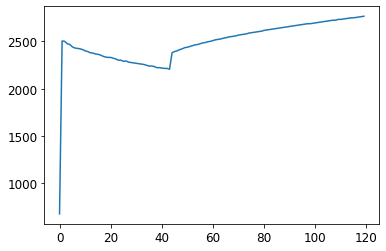

In [118]:
ts.plot(fontsize = 12)
plt.show;

A curva acima é característica de pressão de suprimento, mas está no dataframe de fluxo (flow). Isso indica que a estratégia de pegar os dados do dataframe original de 3 em 3 não foi eficaz, porque em algum momento a ordem se altera (pressão da função, fluxo e pressão de retorno/suprimento)

In [119]:
df_laudo.iloc[6378,:]

Laudo        OK
laudo_new    ok
Name: 6378, dtype: object

In [120]:
6378*3

19134

In [121]:
dataset.iloc[19134,5:15]

cod                           7152
descrição           Cur. Open Flow
sigValvePosition                 1
command_close                    0
command_open                     1
sigDate             20180806 23:40
date                    2018-08-06
time                      23:40:00
sigTime                        120
sigData1                         0
Name: 19134, dtype: object

In [122]:
dataset['descrição'][2]

'Cur. Close Pressure Returne Line'

In [123]:
'Flow' in (dataset['descrição'][1])

True

Uma outra abordagem pra separar os dados em três conjuntos. Dessa vez, será utilizado o texto da descrição para identificar se é pressão de função, fluxo ou pressão de retorno/suprimento.

In [124]:
flow_list = []
function_list = []
return_supply_list = []

In [125]:
for idx, row in enumerate(dataset['descrição']):
  if any(word in row for word in ['Flow']):
    flow_list.append(dataset.iloc[idx,14:134].values)
  elif any(word in row for word in ['Function']):
    function_list.append(dataset.iloc[idx,14:134].values)
  else:
    return_supply_list.append(dataset.iloc[idx,14:134].values)

In [126]:
flow_list[0]

array(['0', '0,002573282', '0,005188067', '0,008549935', '0,01224384',
       '0,016269779', '0,020461738', '0,024819717', '0,029302206',
       '0,033826202', '0,038391698', '0,043040209', '0,047605705',
       '0,052212711', '0,056778211', '0,061260704', '0,065701686',
       '0,070101164', '0,074417643', '0,078692608', '0,082884565',
       '0,087076522', '0,091226973', '0,095377438', '0,099527888',
       '0,103678338', '0,107828788', '0,111979254', '0,116129704',
       '0,120280154', '0,124430604', '0,128581062', '0,132731527',
       '0,136881977', '0,141032428', '0,145182878', '0,149333343',
       '0,153483793', '0,157634243', '0,161784694', '0,165935159',
       '0,170085609', '0,174236059', '0,178386509', '0,18253696',
       '0,186687425', '0,190837875', '0,194988325', '0,19913879',
       '0,203289241', '0,207439691', '0,211590141', '0,215740591',
       '0,219891056', '0,224041507', '0,228191972', '0,232342422',
       '0,236492872', '0,240643322', '0,244793773', '0,24894

In [127]:
def str_float_list(s_list):
  '''
  função para converter a lista string em float
  '''
  for idx, s in enumerate(s_list):
    s = s.replace(',','.')
    s = float(s)
    s_list[idx] = s
  return s_list

In [128]:
flow_list = list(map(str_float_list, flow_list))

In [129]:
ts=pd.Series(flow_list[149])

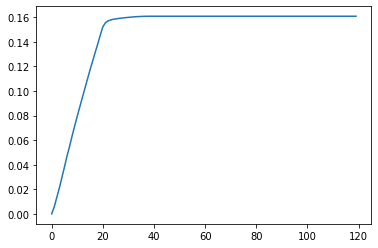

In [130]:
ts.plot()
plt.show()

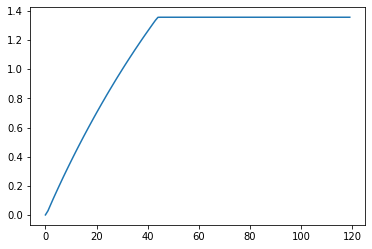

In [131]:
ts2=pd.Series(flow_list[6378])
ts2.plot()
plt.show()

In [132]:
help(str_float_list)

Help on function str_float_list in module __main__:

str_float_list(s_list)
    função para converter a lista string em float



In [133]:
function_list = list(map(str_float_list, function_list))
return_supply_list = list(map(str_float_list, return_supply_list))

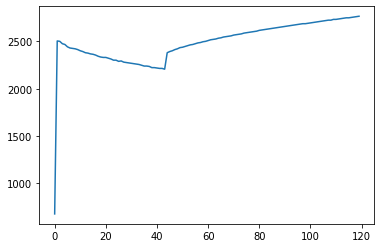

In [134]:
ts2_function=pd.Series(function_list[6378])
ts2_function.plot()
plt.show()

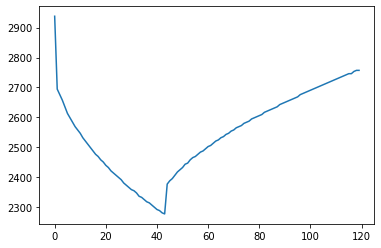

In [135]:
ts2_sup=pd.Series(return_supply_list[6378])
ts2_sup.plot()
plt.show()

In [136]:
df_laudo.shape

(6388, 2)

In [137]:
len(return_supply_list)

6388

In [138]:
laudo_new_list = df_laudo['laudo_new'].tolist()

In [139]:
laudo_new_list[6378]

'ok'

In [140]:
df_data_list = df_data.values.tolist()

In [141]:
df_data_list[6378]

['MPG 8-7',
 'MPG 7',
 'XV-1210103G',
 '[G1-XO]',
 152,
 7152,
 'Cur. Open Flow',
 1,
 0,
 1,
 '20180806 23:40',
 datetime.date(2018, 8, 6),
 datetime.time(23, 40),
 120]

In [142]:
flow_list[0]

array([0.0, 0.002573282, 0.005188067, 0.008549935, 0.01224384,
       0.016269779, 0.020461738, 0.024819717, 0.029302206, 0.033826202,
       0.038391698, 0.043040209, 0.047605705, 0.052212711, 0.056778211,
       0.061260704, 0.065701686, 0.070101164, 0.074417643, 0.078692608,
       0.082884565, 0.087076522, 0.091226973, 0.095377438, 0.099527888,
       0.103678338, 0.107828788, 0.111979254, 0.116129704, 0.120280154,
       0.124430604, 0.128581062, 0.132731527, 0.136881977, 0.141032428,
       0.145182878, 0.149333343, 0.153483793, 0.157634243, 0.161784694,
       0.165935159, 0.170085609, 0.174236059, 0.178386509, 0.18253696,
       0.186687425, 0.190837875, 0.194988325, 0.19913879, 0.203289241,
       0.207439691, 0.211590141, 0.215740591, 0.219891056, 0.224041507,
       0.228191972, 0.232342422, 0.236492872, 0.240643322, 0.244793773,
       0.248944223, 0.253094703, 0.257245153, 0.261395603, 0.265546054,
       0.269696504, 0.273846954, 0.277997404, 0.282147855, 0.286298335,
   

In [143]:
return_supply_list[0]

array([2.764537632, 2.764537632, 2.764537632, 2.764537632, 2.764537632,
       2.764537632, 2.764537632, 2.764537632, 2.764537632, 2.764537632,
       2.764537632, 2.764537632, 2.764537632, 2.764537632, 2.764537632,
       4.146806717, 6.911344528, 9.675881624, 13.82268906, 19.35176325,
       26.26310635, 34.55671978, 42.85033321, 53.9084816, 66.34890747,
       80.17159653, 96.75882339, 114.7283134, 134.0800781, 154.814106,
       178.3126831, 203.193512, 229.4566269, 257.102005, 286.1296463,
       316.5395508, 346.9494781, 378.7416458, 409.1515961, 439.5614777,
       469.971405, 498.9990692, 526.6444244, 552.9075165, 576.4060822,
       597.1401215, 616.4918976, 631.6968842, 644.1372528, 652.4308777,
       657.9599304, 660.7245026, 659.3422394, 653.8131409, 645.5195618,
       633.0791016, 619.256424, 601.2869568, 581.9351807, 561.2010956,
       537.7025757, 512.8217468, 487.940918, 460.295517, 434.0324249,
       406.3870239, 378.7416458, 351.0962906, 324.8331757, 298.5700607,


In [144]:
laudo_new_list[0]

'nulo'

## Criando um DataFrame apenas com os valores númericos (fluxo e pressões) e o laudo

In [145]:
df_values = pd.DataFrame(list(zip(flow_list, return_supply_list, function_list, laudo_new_list)))

In [146]:
df_values.head()

,0,1,2,3
0,"[0.0, 0.002573282, 0.005188067, 0.008549935, 0...","[2.764537632, 2.764537632, 2.764537632, 2.7645...","[-3259.389771, -3259.389771, -3259.389771, -32...",nulo
1,"[0.0, 0.002905318, 0.005727626, 0.009338521, 0...","[10265.65039, 10265.65039, 10261.96387, 10261....","[-3259.389771, -3259.389771, -3259.389771, -32...",nulo
2,"[0.0, 0.002573282, 0.005188067, 0.008549935, 0...","[2.764537632, 2.764537632, 2.764537632, 2.7645...","[-3259.389771, -3259.389771, -3259.389771, -32...",nulo
3,"[0.0, 0.002573282, 0.005188067, 0.008549935, 0...","[2.764537632, 2.764537632, 2.764537632, 2.7645...","[-3259.389771, -3259.389771, -3259.389771, -32...",nulo
4,"[0.0, 0.002573282, 0.005188067, 0.008549935, 0...","[2.764537632, 2.764537632, 2.764537632, 2.7645...","[-3259.389771, -3259.389771, -3259.389771, -32...",nulo


In [147]:
df_flow.head()

,sigData1,sigData2,sigData3,sigData4,sigData5,sigData6,sigData7,sigData8,sigData9,sigData10,sigData11,sigData12,sigData13,sigData14,sigData15,sigData16,sigData17,sigData18,sigData19,sigData20,sigData21,sigData22,sigData23,sigData24,sigData25,sigData26,sigData27,sigData28,sigData29,sigData30,sigData31,sigData32,sigData33,sigData34,sigData35,sigData36,sigData37,sigData38,sigData39,sigData40,...,sigData81,sigData82,sigData83,sigData84,sigData85,sigData86,sigData87,sigData88,sigData89,sigData90,sigData91,sigData92,sigData93,sigData94,sigData95,sigData96,sigData97,sigData98,sigData99,sigData100,sigData101,sigData102,sigData103,sigData104,sigData105,sigData106,sigData107,sigData108,sigData109,sigData110,sigData111,sigData112,sigData113,sigData114,sigData115,sigData116,sigData117,sigData118,sigData119,sigData120
0,0,0.002573282,0.005188067,0.008549935,0.01224384,0.016269779,0.020461738,0.024819717,0.029302206,0.033826202,0.038391698,0.043040209,0.047605705,0.052212711,0.056778211,0.061260704,0.065701686,0.070101164,0.074417643,0.078692608,0.082884565,0.087076522,0.091226973,0.095377438,0.099527888,0.103678338,0.107828788,0.111979254,0.116129704,0.120280154,0.124430604,0.128581062,0.132731527,0.136881977,0.141032428,0.145182878,0.149333343,0.153483793,0.157634243,0.161784694,...,0.331953317,0.336103767,0.340254217,0.344404697,0.348555118,0.352705598,0.356856018,0.361006498,0.365156919,0.369307399,0.373457879,0.377608299,0.381758779,0.3859092,0.39005968,0.394168586,0.398194551,0.40188846,0.405125827,0.407823622,0.409898818,0.411434501,0.412555128,0.413343728,0.413883269,0.414256811,0.414505839,0.414630353,0.414754868,0.414796352,0.414837867,0.414879382,0.414879382,0.414879382,0.414879382,0.414879382,0.414879382,0.414879382,0.414879382,0.414879382
1,0,0.002905318,0.005727626,0.009338521,0.013198444,0.017265888,0.021540856,0.025857329,0.030298315,0.034739301,0.03922179,0.043745786,0.048228275,0.052710768,0.05715175,0.061592739,0.065950714,0.070308693,0.074583657,0.078817122,0.082967579,0.08711803,0.09126848,0.095418938,0.099569395,0.103719845,0.107870296,0.112020753,0.116171211,0.120321661,0.124472111,0.128622577,0.132773027,0.136923477,0.141073927,0.145224392,0.149374843,0.153525293,0.157675743,0.161826208,...,0.331994802,0.336145282,0.340295732,0.344446182,0.348596632,0.352747083,0.356897533,0.361047983,0.365198433,0.369348913,0.373499364,0.377649814,0.381800264,0.385950714,0.390101165,0.394251615,0.398402095,0.402386487,0.405955911,0.408819735,0.410936475,0.412347585,0.413302213,0.413924783,0.414298326,0.414547354,0.414713353,0.414796352,0.414879382,0.414879382,0.414920866,0.414920866,0.414920866,0.414920866,0.414920866,0.414920866,0.414920866,0.414920866,0.414920866,0.414920866
2,0,0.002573282,0.005188067,0.008549935,0.01224384,0.016269779,0.020461738,0.024819717,0.029302206,0.033826202,0.038391698,0.043040209,0.047605705,0.052212711,0.056778211,0.061260704,0.065701686,0.070101164,0.074417643,0.078692608,0.082884565,0.087076522,0.091226973,0.095377438,0.099527888,0.103678338,0.107828788,0.111979254,0.116129704,0.120280154,0.124430604,0.128581062,0.132731527,0.136881977,0.141032428,0.145182878,0.149333343,0.153483793,0.157634243,0.161784694,...,0.331953317,0.336103767,0.340254217,0.344404697,0.348555118,0.352705598,0.356856018,0.361006498,0.365156919,0.369307399,0.373457879,0.377608299,0.381758779,0.3859092,0.39005968,0.394168586,0.398194551,0.40188846,0.405125827,0.407823622,0.409898818,0.411434501,0.412555128,0.413343728,0.413883269,0.414256811,0.414505839,0.414630353,0.414754868,0.414796352,0.414837867,0.414879382,0.414879382,0.414879382,0.414879382,0.414879382,0.414879382,0.414879382,0.414879382,0.414879382
3,0,0.002573282,0.005188067,0.008549935,0.01224384,0.016269779,0.020461738,0.024819717,0.029302206,0.033826202,0.038391698,0.043040209,0.047605705,0.052212711,0.056778211,0.061260704,0.065701686,0.070101164,0.074417643,0.078692608,0.082884565,0.087076522,0.091226973,0.095377438,0.099527888,0.103678338,0.107828788,0.111979254,0.

In [148]:
type(df_flow['sigData10'][0])

str

In [149]:
columns_names = df_flow.columns

In [150]:
df_flow = pd.DataFrame(flow_list, columns=columns_names)
df_pressure_function = pd.DataFrame(function_list, columns=columns_names)
df_return_supply = pd.DataFrame(return_supply_list, columns=columns_names)

In [151]:
df_flow.head()

,sigData1,sigData2,sigData3,sigData4,sigData5,sigData6,sigData7,sigData8,sigData9,sigData10,sigData11,sigData12,sigData13,sigData14,sigData15,sigData16,sigData17,sigData18,sigData19,sigData20,sigData21,sigData22,sigData23,sigData24,sigData25,sigData26,sigData27,sigData28,sigData29,sigData30,sigData31,sigData32,sigData33,sigData34,sigData35,sigData36,sigData37,sigData38,sigData39,sigData40,...,sigData81,sigData82,sigData83,sigData84,sigData85,sigData86,sigData87,sigData88,sigData89,sigData90,sigData91,sigData92,sigData93,sigData94,sigData95,sigData96,sigData97,sigData98,sigData99,sigData100,sigData101,sigData102,sigData103,sigData104,sigData105,sigData106,sigData107,sigData108,sigData109,sigData110,sigData111,sigData112,sigData113,sigData114,sigData115,sigData116,sigData117,sigData118,sigData119,sigData120
0,0.0,0.002573,0.005188,0.008550,0.012244,0.016270,0.020462,0.024820,0.029302,0.033826,0.038392,0.043040,0.047606,0.052213,0.056778,0.061261,0.065702,0.070101,0.074418,0.078693,0.082885,0.087077,0.091227,0.095377,0.099528,0.103678,0.107829,0.111979,0.116130,0.120280,0.124431,0.128581,0.132732,0.136882,0.141032,0.145183,0.149333,0.153484,0.157634,0.161785,...,0.331953,0.336104,0.340254,0.344405,0.348555,0.352706,0.356856,0.361006,0.365157,0.369307,0.373458,0.377608,0.381759,0.385909,0.390060,0.394169,0.398195,0.401888,0.405126,0.407824,0.409899,0.411435,0.412555,0.413344,0.413883,0.414257,0.414506,0.414630,0.414755,0.414796,0.414838,0.414879,0.414879,0.414879,0.414879,0.414879,0.414879,0.414879,0.414879,0.414879
1,0.0,0.002905,0.005728,0.009339,0.013198,0.017266,0.021541,0.025857,0.030298,0.034739,0.039222,0.043746,0.048228,0.052711,0.057152,0.061593,0.065951,0.070309,0.074584,0.078817,0.082968,0.087118,0.091268,0.095419,0.099569,0.103720,0.107870,0.112021,0.116171,0.120322,0.124472,0.128623,0.132773,0.136923,0.141074,0.145224,0.149375,0.153525,0.157676,0.161826,...,0.331995,0.336145,0.340296,0.344446,0.348597,0.352747,0.356898,0.361048,0.365198,0.369349,0.373499,0.377650,0.381800,0.385951,0.390101,0.394252,0.398402,0.402386,0.405956,0.408820,0.410936,0.412348,0.413302,0.413925,0.414298,0.414547,0.414713,0.414796,0.414879,0.414879,0.414921,0.414921,0.414921,0.414921,0.414921,0.414921,0.414921,0.414921,0.414921,0.414921
2,0.0,0.002573,0.005188,0.008550,0.012244,0.016270,0.020462,0.024820,0.029302,0.033826,0.038392,0.043040,0.047606,0.052213,0.056778,0.061261,0.065702,0.070101,0.074418,0.078693,0.082885,0.087077,0.091227,0.095377,0.099528,0.103678,0.107829,0.111979,0.116130,0.120280,0.124431,0.128581,0.132732,0.136882,0.141032,0.145183,0.149333,0.153484,0.157634,0.161785,...,0.331953,0.336104,0.340254,0.344405,0.348555,0.352706,0.356856,0.361006,0.365157,0.369307,0.373458,0.377608,0.381759,0.385909,0.390060,0.394169,0.398195,0.401888,0.405126,0.407824,0.409899,0.411435,0.412555,0.413344,0.413883,0.414257,0.414506,0.414630,0.414755,0.414796,0.414838,0.414879,0.414879,0.414879,0.414879,0.414879,0.414879,0.414879,0.414879,0.414879
3,0.0,0.002573,0.005188,0.008550,0.012244,0.016270,0.020462,0.024820,0.029302,0.033826,0.038392,0.043040,0.047606,0.052213,0.056778,0.061261,0.065702,0.070101,0.074418,0.078693,0.082885,0.087077,0.091227,0.095377,0.099528,0.103678,0.107829,0.111979,0.116130,0.120280,0.124431,0.128581,0.132732,0.136882,0.141032,0.145183,0.149333,0.153484,0.157634,0.161785,...,0.331953,0.336104,0.340254,0.344405,0.348555,0.352706,0.356856,0.361006,0.365157,0.369307,0.373458,0.377608,0.381759,0.385909,0.390060,0.394169,0.398195,0.401888,0.405126,0.407824,0.409899,0.411435,0.412555,0.413344,0.413883,0.414257,0.414506,0.414630,0.414755,0.414796,0.414838,0.414879,0.414879,0.414879,0.414879,0.414879,0.414879,0.414879,0.414879,0.414879
4,0.0,0.002573,0.005188,0.008550,0.012244,0.016270,0.020462,0.024820,0.029302,0.033826,0.038392,0.043040,0.047606,0.052213,0.056778,0.061261,0.065702,0.070101,0.074418,0.078693,0.082885,0.087077,0.091227,0.095377,0.099528,0.103678,0.107829,0.111979,0.116130,0.120280,0.124431,0.128581,0.132732,0.136

In [152]:
type(df_flow['sigData10'][0])

numpy.float64

In [153]:
type(df_pressure_function['sigData10'][0])

numpy.float64

In [154]:
df_values = pd.concat([df_flow,df_pressure_function,df_return_supply, df_laudo['laudo_new']], axis=1, ignore_index=True)

In [155]:
df_values.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360
0,0.0,0.002573,0.005188,0.008550,0.012244,0.016270,0.020462,0.024820,0.029302,0.033826,0.038392,0.043040,0.047606,0.052213,0.056778,0.061261,0.065702,0.070101,0.074418,0.078693,0.082885,0.087077,0.091227,0.095377,0.099528,0.103678,0.107829,0.111979,0.116130,0.120280,0.124431,0.128581,0.132732,0.136882,0.141032,0.145183,0.149333,0.153484,0.157634,0.161785,...,71.877983,60.819826,51.14395,41.468064,33.174454,26.263106,19.351763,13.822689,9.675882,5.529075,2.764538,1.382269,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nulo
1,0.0,0.002905,0.005728,0.009339,0.013198,0.017266,0.021541,0.025857,0.030298,0.034739,0.039222,0.043746,0.048228,0.052711,0.057152,0.061593,0.065951,0.070309,0.074584,0.078817,0.082968,0.087118,0.091268,0.095419,0.099569,0.103720,0.107870,0.112021,0.116171,0.120322,0.124472,0.128623,0.132773,0.136923,0.141074,0.145224,0.149375,0.153525,0.157676,0.161826,...,10188.243160,10195.614260,10202.98730,10210.359380,10214.044920,10217.730470,10221.417970,10221.417970,10225.103520,10225.103520,10228.789060,10228.789060,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,nulo
2,0.0,0.002573,0.005188,0.008550,0.012244,0.016270,0.020462,0.024820,0.029302,0.033826,0.038392,0.043040,0.047606,0.052213,0.056778,0.061261,0.065702,0.070101,0.074418,0.078693,0.082885,0.087077,0.091227,0.095377,0.099528,0.103678,0.107829,0.111979,0.116130,0.120280,0.124431,0.128581,0.132732,0.136882,0.141032,0.145183,0.149333,0.153484,0.157634,0.161785,...,71.877983,60.819826,51.14395,41.468064,33.174454,26.263106,19.351763,13.822689,9.675882,5.529075,2.764538,1.382269,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nulo
3,0.0,0.002573,0.005188,0.008550,0.012244,0.016270,0.020462,0.024820,0.029302,0.033826,0.038392,0.043040,0.047606,0.052213,0.056778,0.061261,0.065702,0.070101,0.074418,0.078693,0.082885,0.087077,0.091227,0.095377,0.099528,0.103678,0.107829,0.111979,0.116130,0.120280,0.124431,0.128581,0.132732,0.136882,0.141032,0.145183,0.149333,0.153484,0.157634,0.161785,...,71.877983,60.819826,51.14395,41.468064,33.174454,26.263106,19.351763,13.822689,9.675882,5.529075,2.764538,1.382269,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nulo
4,0.0,0.002573,0.005188,0.008550,0.012244,0.016270,0.020462,0.024820,0.029302,0.033826,0.038392,0.043040,0.047606,0.052213,0.056778,0.061261,0.065702,0.070101,0.074418,0.078693,0.082885,0.087077,0.091227,0.095377,0.099528,0.103678,0.107829,0.111979,0.116130,0.120280,0.124431,0.128581,0.132732,0.136882,0.141032,0.145183,0.149333,0.153484,0.157634,0.161785,...,71.877983,60.819826,51.14395,41.468064,33.174454,26.263106,19.351763,13.822689,9.675882,5.529075,2.764538,1.382269,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nulo


In [156]:
df_values[360].value_counts()

ok                     4057
already_on_position    1743
alert                   438
nulo                    150
Name: 360, dtype: int64

In [157]:
df_values[361] = df_values[360].apply(lambda x: 1 if x == 'alert' else x)
df_values[361] = df_values[361].apply(lambda x: 2 if x == 'nulo' else x)
df_values[361] = df_values[361].apply(lambda x: 0 if x in ['already_on_position', 'ok'] else x)

In [158]:
df_values[361].value_counts()

0    5800
1     438
2     150
Name: 361, dtype: int64

In [159]:
data = df_values.drop([360], axis=1)

In [160]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,361
0,0.0,0.002573,0.005188,0.008550,0.012244,0.016270,0.020462,0.024820,0.029302,0.033826,0.038392,0.043040,0.047606,0.052213,0.056778,0.061261,0.065702,0.070101,0.074418,0.078693,0.082885,0.087077,0.091227,0.095377,0.099528,0.103678,0.107829,0.111979,0.116130,0.120280,0.124431,0.128581,0.132732,0.136882,0.141032,0.145183,0.149333,0.153484,0.157634,0.161785,...,71.877983,60.819826,51.14395,41.468064,33.174454,26.263106,19.351763,13.822689,9.675882,5.529075,2.764538,1.382269,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2
1,0.0,0.002905,0.005728,0.009339,0.013198,0.017266,0.021541,0.025857,0.030298,0.034739,0.039222,0.043746,0.048228,0.052711,0.057152,0.061593,0.065951,0.070309,0.074584,0.078817,0.082968,0.087118,0.091268,0.095419,0.099569,0.103720,0.107870,0.112021,0.116171,0.120322,0.124472,0.128623,0.132773,0.136923,0.141074,0.145224,0.149375,0.153525,0.157676,0.161826,...,10188.243160,10195.614260,10202.98730,10210.359380,10214.044920,10217.730470,10221.417970,10221.417970,10225.103520,10225.103520,10228.789060,10228.789060,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,10228.78906,2
2,0.0,0.002573,0.005188,0.008550,0.012244,0.016270,0.020462,0.024820,0.029302,0.033826,0.038392,0.043040,0.047606,0.052213,0.056778,0.061261,0.065702,0.070101,0.074418,0.078693,0.082885,0.087077,0.091227,0.095377,0.099528,0.103678,0.107829,0.111979,0.116130,0.120280,0.124431,0.128581,0.132732,0.136882,0.141032,0.145183,0.149333,0.153484,0.157634,0.161785,...,71.877983,60.819826,51.14395,41.468064,33.174454,26.263106,19.351763,13.822689,9.675882,5.529075,2.764538,1.382269,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2
3,0.0,0.002573,0.005188,0.008550,0.012244,0.016270,0.020462,0.024820,0.029302,0.033826,0.038392,0.043040,0.047606,0.052213,0.056778,0.061261,0.065702,0.070101,0.074418,0.078693,0.082885,0.087077,0.091227,0.095377,0.099528,0.103678,0.107829,0.111979,0.116130,0.120280,0.124431,0.128581,0.132732,0.136882,0.141032,0.145183,0.149333,0.153484,0.157634,0.161785,...,71.877983,60.819826,51.14395,41.468064,33.174454,26.263106,19.351763,13.822689,9.675882,5.529075,2.764538,1.382269,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2
4,0.0,0.002573,0.005188,0.008550,0.012244,0.016270,0.020462,0.024820,0.029302,0.033826,0.038392,0.043040,0.047606,0.052213,0.056778,0.061261,0.065702,0.070101,0.074418,0.078693,0.082885,0.087077,0.091227,0.095377,0.099528,0.103678,0.107829,0.111979,0.116130,0.120280,0.124431,0.128581,0.132732,0.136882,0.141032,0.145183,0.149333,0.153484,0.157634,0.161785,...,71.877983,60.819826,51.14395,41.468064,33.174454,26.263106,19.351763,13.822689,9.675882,5.529075,2.764538,1.382269,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2


In [161]:
data = data[data[361] != 2]

In [162]:
data.shape

(6238, 361)

In [163]:
# split into independent variables and target variable
X = data.drop([361], axis=1) 
y = data[361]
# show the shape of x and y  
print("X shape: {}".format(X.shape)) 
print("y shape: {}".format(y.shape))

X shape: (6238, 360)
y shape: (6238,)


In [164]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359
38,0.0,0.034864,0.070018,0.105173,0.138542,0.173032,0.205198,0.238195,0.270029,0.301281,0.332493,0.362957,0.393090,0.422516,0.451569,0.480208,0.508306,0.536529,0.563798,0.590942,0.617671,0.643860,0.668140,0.695533,0.720560,0.745754,0.770283,0.794770,0.818553,0.842625,0.865619,0.888903,0.911813,0.934350,0.956638,0.978719,1.000550,1.021759,1.042843,1.064384,...,2889.863281,2897.235352,2904.607666,2911.979736,2923.037842,2930.409668,2934.095947,2945.154053,2948.840088,2956.212402,2963.584473,2970.956299,2974.642578,2982.014404,2989.386719,2996.758789,3000.444824,3007.816895,3011.502930,3018.875244,3022.561035,3026.247314,3033.619141,3037.305420,3044.677246,3048.363525,3052.049561,3055.735840,3063.107666,3066.793945,3070.479736,3074.165771,3077.852051,3085.223877,3085.223877,3088.910156,3096.281982,3099.968262,3099.968262,3107.340088
39,0.0,0.022329,0.045863,0.069728,0.093219,0.116462,0.140244,0.163652,0.187019,0.210553,0.234210,0.257121,0.280654,0.303606,0.326599,0.349800,0.373416,0.396202,0.418988,0.442023,0.464809,0.487512,0.510423,0.532960,0.555787,0.578117,0.600944,0.623357,0.645313,0.667351,0.689930,0.711844,0.734257,0.755798,0.777920,0.799253,0.820918,0.842501,0.864166,0.885956,...,718.779785,718.779785,717.397522,717.397522,717.397522,717.397522,716.015259,716.015259,716.015259,714.632935,714.632935,714.632935,713.250732,713.250732,713.250732,713.250732,711.868469,711.868469,711.868469,711.868469,711.868469,710.486145,710.486145,710.486145,710.486145,710.486145,709.103882,709.103882,709.103882,709.103882,709.103882,709.103882,709.103882,707.721680,707.721680,707.721680,707.721680,707.721680,707.721680,707.721680
40,0.0,0.038350,0.077530,0.116960,0.154895,0.192789,0.229230,0.265297,0.300742,0.335979,0.370594,0.403632,0.437458,0.470910,0.503035,0.534703,0.566537,0.597416,0.628005,0.658428,0.688104,0.717447,0.746625,0.775637,0.803611,0.831876,0.859310,0.886163,0.913473,0.940119,0.966558,0.992664,1.017940,1.043300,1.068410,1.093022,1.117759,1.142080,1.166153,1.189686,...,2989.386719,2996.758789,3004.131104,3011.502930,3018.875244,3026.247314,3029.933350,3037.305420,3044.677246,3052.049561,3055.735840,3063.107666,3066.793945,3074.165771,3077.852051,3085.223877,3088.910156,3096.281982,3099.968262,3107.340088,3111.026367,3114.712402,3118.398682,3122.084473,3129.456787,3133.142578,3136.828613,3140.514893,3144.200928,3147.886719,3151.572998,3155.259033,3158.944824,3162.631104,3166.317139,3170.003418,3173.689209,3177.375244,3181.061523,3184.747314
41,0.0,0.022371,0.046776,0.070973,0.094921,0.119243,0.143689,0.167097,0.191128,0.214994,0.238527,0.262018,0.285427,0.309416,0.333240,0.356690,0.380265,0.403798,0.427206,0.450283,0.473359,0.496560,0.519554,0.543211,0.565956,0.588783,0.611486,0.634314,0.657473,0.679969,0.702921,0.724918,0.747621,0.769702,0.792114,0.814029,0.836150,0.858729,0.880685,0.902226,...,722.926636,722.926636,722.926636,722.926636,722.926636,722.926636,722.926636,722.926636,722.926636,722.926636,722.926636,721.544312,721.544312,721.544312,721.544312,721.544312,721.544312,721.544312,721.544312,721.544312,721.544312,721.544312,721.544312,721.544312,721.544312,721.544312,721.544312,721.544312,721.544312,720.162048,721.544312,720.162048,720.162048,720.162048,720.162048,720.162048,720.162048,720.162048,720.162048,720.162048
42,0.0,0.043289,0.086495,0.130158,0.171455,0.212462,0.252929,0.293064,0.331372,0.369390,0.407450,0.443476,0.478257,0.514822,0.548482,0.583512,0.617090,0.649588,0.682044,0.713795,0.745089,0.775637,0.806392,0.835943,0.865079,0.893676,0.921899,0.950205,0.977722,1.004866,1.031180,1.057577,1.083642,1.109250,1.134278,1.159305,1.183460,1.207948,1.231813,1.254973,...,2963.584473,2970.956299,2978.328613,2985.700684,2989.386719,2996.758789,300

In [165]:
y.head()

38    0
39    0
40    0
41    0
42    0
Name: 361, dtype: int64

In [166]:
# Separating out the features
x = X.values
x[1,120:130]

array([3802.621582, 1098.903809, 1094.756836, 1086.463257, 1094.756836,
       1090.610107, 1086.463257, 1090.610107, 1086.463257, 1086.463257])

### Aplicando transformação nos dados utilizando a média e desvio padrão

In [167]:
# Standardizing the features
x = StandardScaler().fit_transform(x)
x[1,120:130]

array([ 0.97934925, -1.95564957, -1.77113263, -1.55350508, -1.15304269,
       -1.02687551, -1.02291247, -1.01757511, -1.00903228, -0.987935  ])

In [168]:
X = pd.DataFrame(x)

In [169]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359
0,0.0,1.888255,1.400007,1.270775,1.182935,1.142468,1.082019,1.053351,1.025188,0.999368,0.978471,0.957086,0.937528,0.917544,0.898417,0.880810,0.863800,0.850115,0.835000,0.822149,0.809963,0.798095,0.781462,0.776742,0.766183,0.757627,0.748521,0.741177,0.734317,0.731313,0.728159,0.728487,0.730500,0.733971,0.739067,0.745389,0.752544,0.759514,0.766804,0.775933,...,0.586818,0.591197,0.595663,0.600183,0.607378,0.611793,0.613620,0.620995,0.622823,0.627475,0.632155,0.636668,0.638582,0.643214,0.647876,0.652499,0.654558,0.659130,0.661034,0.665790,0.667691,0.669689,0.674508,0.676466,0.681200,0.683372,0.685344,0.687362,0.692065,0.694182,0.696227,0.698296,0.700428,0.705298,0.704533,0.706615,0.711424,0.713533,0.712946,0.717726
1,0.0,0.896884,0.603204,0.516494,0.443347,0.368842,0.319368,0.287837,0.270538,0.262640,0.259935,0.255447,0.256881,0.255772,0.255126,0.256474,0.260195,0.260607,0.261625,0.264243,0.266332,0.268745,0.271816,0.274147,0.277750,0.280172,0.284262,0.287820,0.291205,0.296472,0.304284,0.312042,0.322452,0.332227,0.344663,0.356389,0.369690,0.383512,0.397745,0.412772,...,-1.035761,-1.035955,-1.037184,-1.037393,-1.037502,-1.037692,-1.038855,-1.038999,-1.039069,-1.040213,-1.040363,-1.040461,-1.041615,-1.041736,-1.041836,-1.041955,-1.043118,-1.043225,-1.043378,-1.043483,-1.043601,-1.044766,-1.044864,-1.044947,-1.045056,-1.045147,-1.046324,-1.046421,-1.046539,-1.046619,-1.046727,-1.046845,-1.046948,-1.047986,-1.048123,-1.048318,-1.048381,-1.048452,-1.048577,-1.048712
2,0.0,2.164001,1.647810,1.521613,1.449782,1.412642,1.364175,1.331681,1.304408,1.281117,1.257025,1.226736,1.206119,1.186872,1.163339,1.141712,1.124372,1.105899,1.089231,1.074979,1.060449,1.047242,1.035077,1.024382,1.012367,1.002915,0.992598,0.982894,0.977104,0.973188,0.971689,0.972536,0.974393,0.979107,0.985730,0.993147,1.002355,1.011894,1.021501,1.030964,...,0.661197,0.665534,0.669962,0.674446,0.678849,0.683226,0.685019,0.689618,0.694155,0.698776,0.700687,0.705165,0.707049,0.711652,0.713549,0.718143,0.720181,0.724724,0.726602,0.731334,0.733208,0.735183,0.737254,0.739187,0.743898,0.746054,0.748004,0.750000,0.751958,0.754057,0.756083,0.758133,0.760248,0.762382,0.764314,0.766380,0.768455,0.770546,0.772659,0.774708
3,0.0,0.900167,0.633323,0.542991,0.471116,0.406871,0.359815,0.323215,0.307893,0.298701,0.291492,0.287915,0.285776,0.288110,0.289309,0.289459,0.290839,0.292515,0.294164,0.295186,0.296739,0.299379,0.301322,0.305840,0.307892,0.310552,0.313165,0.316800,0.322310,0.327775,0.335626,0.342792,0.353165,0.363511,0.375988,0.388416,0.402154,0.417551,0.431865,0.445887,...,-1.032662,-1.032857,-1.033057,-1.033268,-1.033378,-1.033571,-1.033706,-1.033852,-1.033924,-1.034043,-1.034195,-1.035324,-1.035453,-1.035576,-1.035679,-1.035801,-1.035940,-1.036051,-1.036206,-1.036314,-1.036435,-1.036579,-1.036680,-1.036766,-1.036877,-1.036972,-1.037130,-1.037230,-1.037351,-1.038454,-1.037545,-1.038686,-1.038791,-1.038812,-1.038952,-1.039150,-1.039216,-1.039290,-1.039416,-1.039555
4,0.0,2.554640,1.943531,1.802480,1.720015,1.681680,1.642432,1.616830,1.582874,1.552419,1.526476,1.490882,1.453101,1.431254,1.397283,1.375392,1.350585,1.325068,1.303199,1.282406,1.263111,1.244256,1.228206,1.210819,1.194576,1.178932,1.164192,1.152271,1.141440,1.133821,1.127600,1.125213,1.125384,1.127497,1.131090,1.136817,1.142387,1.150055,1.157123,1.163844,...,0.641914,0.646262,0.650699,0.655193,0.656858,0.661247,0.665796,0.667659,0.672207,0.674095,0.678757,0.680506,0.685140,0.687015,0.691658,0.693526,0.695573,0.697393,0.702014,0.704024,0.705909,0.707894,0.709973,0.711917,0.713912,0.716075,0.718036,0.720042,0.722012,0.724120,0.728876,0.728214,0.730338,0.732481,0.734423,0.736497,0.738581,0.737967,0.740088,0.742147


In [170]:
y.reset_index(inplace = True, drop=True)

In [171]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: 361, dtype: int64

#### Gerando os conjuntos de treino e teste

In [172]:
#split the data into train and test 
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size = 0.2, stratify=y, random_state=42 )

In [173]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359
1902,0.0,-0.869200,-0.909627,-0.966453,-0.884794,-0.601738,-0.392601,-0.220232,-0.082638,0.035488,0.132492,0.211697,0.283515,0.333614,0.392287,0.434912,0.474707,0.505233,0.535084,0.563876,0.588112,0.609935,0.629909,0.649457,0.668496,0.685045,0.700047,0.714392,0.729964,0.744802,0.762105,0.780811,0.801560,0.821379,0.843851,0.867469,0.889391,0.912997,0.936116,0.958653,...,-1.033695,-1.033890,-1.035121,-1.035331,-1.034409,-1.035632,-1.035766,-1.035911,-1.035982,-1.037128,-1.037279,-1.037379,-1.037507,-1.037629,-1.037731,-1.037853,-1.037991,-1.038101,-1.038255,-1.039387,-1.038482,-1.039649,-1.039749,-1.039834,-1.039944,-1.040038,-1.040194,-1.040294,-1.041435,-1.041516,-1.041626,-1.041746,-1.041850,-1.041870,-1.042009,-1.042206,-1.042271,-1.042344,-1.042470,-1.042607
5656,0.0,1.474637,1.806623,1.874906,1.930649,1.973421,1.992813,2.001292,2.006986,2.000994,1.986485,1.977352,1.960132,1.945657,1.930332,1.917662,1.904602,1.893478,1.884133,1.873276,1.863865,1.857779,1.850241,1.843136,1.837535,1.829093,1.823144,1.817816,1.804940,1.720233,1.635089,1.558937,1.489460,1.426330,1.368960,1.316203,1.267292,1.221616,1.178298,1.137572,...,0.873317,0.872025,0.873595,0.875232,0.874022,0.872798,0.874501,0.876273,0.875228,0.877028,0.876128,0.877775,0.876849,0.878642,0.877731,0.879520,0.878772,0.877775,0.879592,0.878809,0.880621,0.879817,0.881842,0.880990,0.882926,0.882319,0.884222,0.883446,0.882634,0.884694,0.883956,0.885967,0.885328,0.887422,0.886592,0.885911,0.887948,0.887288,0.889370,0.888672
60,0.0,0.604725,0.938628,1.006688,1.030547,1.034626,1.032312,1.028204,1.027452,1.023296,1.020345,1.017344,1.010643,1.005087,0.994985,0.985131,0.979879,0.971991,0.965649,0.959448,0.954321,0.949860,0.943743,0.938927,0.935227,0.931870,0.927283,0.925593,0.925298,0.926234,0.928731,0.936026,0.943394,0.953146,0.964297,0.976683,0.989351,1.003885,1.014043,1.031049,...,0.672217,0.676547,0.678217,0.679947,0.681598,0.683226,0.676780,0.681384,0.683181,0.685064,0.686980,0.685986,0.685140,0.687015,0.688921,0.690791,0.692838,0.683728,0.688354,0.693100,0.692260,0.694249,0.696333,0.690101,0.694830,0.696998,0.698966,0.698255,0.697510,0.696904,0.698948,0.701016,0.703147,0.702580,0.696381,0.701181,0.703276,0.702673,0.704803,0.706872
2480,0.0,0.017125,-0.059430,-0.103535,-0.171621,-0.262319,-0.334611,-0.376659,-0.403741,-0.420501,-0.429168,-0.433811,-0.454167,-0.522646,-0.583012,-0.633932,-0.677716,-0.715628,-0.748724,-0.778021,-0.804102,-0.827194,-0.848196,-0.867053,-0.884153,-0.899812,-0.914163,-0.927571,-0.940357,-0.952756,-0.965038,-0.976927,-0.988489,-0.999730,-1.010564,-1.020942,-1.030808,-1.040056,-1.048827,-1.057018,...,-1.021298,-1.020468,-1.020674,-1.020890,-1.021008,-1.021208,-1.021349,-1.021500,-1.021579,-1.021702,-1.021859,-1.021967,-1.022102,-1.022231,-1.022339,-1.022467,-1.022610,-1.022727,-1.022888,-1.023001,-1.023127,-1.023276,-1.023381,-1.023472,-1.023588,-1.023686,-1.023848,-1.023953,-1.024079,-1.024166,-1.024282,-1.024406,-1.024515,-1.024541,-1.024686,-1.024888,-1.024958,-1.025036,-1.025167,-1.025309
3963,0.0,0.975669,1.332922,1.409442,1.444364,1.469401,1.475770,1.482567,1.482883,1.481308,1.474589,1.463917,1.452348,1.440031,1.427835,1.412351,1.402217,1.389058,1.377315,1.366372,1.356988,1.349367,1.340864,1.331944,1.324127,1.316766,1.310069,1.305841,1.301742,1.301353,1.303839,1.308640,1.315482,1.325007,1.337269,1.313234,1.265169,1.220311,1.177355,1.136897,...,0.622630,0.626989,0.628685,0.627688,0.629369,0.631025,0.632842,0.634720,0.636541,0.638444,0.640379,0.639408,0.641320,0.643214,0.645139,0.647028,0.646355,0.650931,0.650106,0.652135,0.654041,0.656044,0.655411,0.657377,0.659392,0.658844,0.660825,0.662851,0.664841,0.666966,0.666300,0.668377,0.670517,0.672679,0.671926,0.674015,0.676119,0.675524

In [174]:
y_train.head()

1902    0
5656    0
60      0
2480    0
3963    0
Name: 361, dtype: int64

## Hiperparâmetros

In [175]:
contamination = 0.172
epochs = 100

## SVM com dados escalonados

In [176]:
# create the OCSVM model
clf_ocsvm = OCSVM(contamination= contamination)

In [177]:
clf_ocsvm

OCSVM(cache_size=200, coef0=0.0, contamination=0.172, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)

In [178]:
clf_ocsvm.fit(X_train)

OCSVM(cache_size=200, coef0=0.0, contamination=0.172, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)

In [179]:
# Get the prediction labels of the training data
y_train_pred = clf_ocsvm.labels_  # binary labels (0: inliers, 1: outliers)

clf_name ='OCSVM'

# Outlier scores
y_train_scores = clf_ocsvm.decision_scores_ 
# Evaluate on the training data
evaluate_print(clf_name, y_train, y_train_scores)

OCSVM ROC:0.5495, precision @ rank n:0.1314


In [180]:
!pip install scikit-plot

In [181]:
import scikitplot as skplt

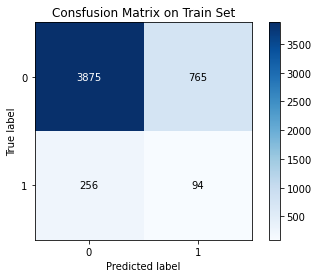

In [182]:
# plot the comfusion matrix  in the train set 

skplt.metrics.plot_confusion_matrix(y_train,y_train_pred, 
                                    normalize=False,
                                    title="Consfusion Matrix on Train Set")
plt.show()

60 anomalias previstas corretamente e 290 não previstas

In [183]:
y_test_scores = clf_ocsvm.decision_function(X_test)  # outlier scores

# Evaluate on the training data
evaluate_print(clf_name, y_test,y_test_scores)

OCSVM ROC:0.4895, precision @ rank n:0.0341


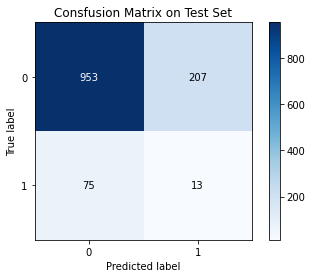

In [184]:
# plot the comfusion matrix in the test set 
y_preds = clf_ocsvm.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test,y_preds, normalize=False, title='Consfusion Matrix on Test Set') 
plt.show()

Sem normalizar os dados: 21 não anomalias e 88 anomalias corretors, errou 1139 não anomalias
Normalizandos os dados: acertou 953 não anomalis e 13 anomalias, errou 75 anomalias e 207 não anomalias

## Aplicando PCA nos dados e fazendo visualização em 2D

In [185]:
from pyod.models.pca import PCA

In [186]:
n_components = 2

In [187]:
clf_pca = PCA(n_components=n_components)
clf_pca.fit(X_train)

PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=2,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [188]:
df_train = pd.DataFrame(X_train)
df_train['y'] = y_train

In [189]:
df_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,y
1902,0.0,-0.869200,-0.909627,-0.966453,-0.884794,-0.601738,-0.392601,-0.220232,-0.082638,0.035488,0.132492,0.211697,0.283515,0.333614,0.392287,0.434912,0.474707,0.505233,0.535084,0.563876,0.588112,0.609935,0.629909,0.649457,0.668496,0.685045,0.700047,0.714392,0.729964,0.744802,0.762105,0.780811,0.801560,0.821379,0.843851,0.867469,0.889391,0.912997,0.936116,0.958653,...,-1.033890,-1.035121,-1.035331,-1.034409,-1.035632,-1.035766,-1.035911,-1.035982,-1.037128,-1.037279,-1.037379,-1.037507,-1.037629,-1.037731,-1.037853,-1.037991,-1.038101,-1.038255,-1.039387,-1.038482,-1.039649,-1.039749,-1.039834,-1.039944,-1.040038,-1.040194,-1.040294,-1.041435,-1.041516,-1.041626,-1.041746,-1.041850,-1.041870,-1.042009,-1.042206,-1.042271,-1.042344,-1.042470,-1.042607,0
5656,0.0,1.474637,1.806623,1.874906,1.930649,1.973421,1.992813,2.001292,2.006986,2.000994,1.986485,1.977352,1.960132,1.945657,1.930332,1.917662,1.904602,1.893478,1.884133,1.873276,1.863865,1.857779,1.850241,1.843136,1.837535,1.829093,1.823144,1.817816,1.804940,1.720233,1.635089,1.558937,1.489460,1.426330,1.368960,1.316203,1.267292,1.221616,1.178298,1.137572,...,0.872025,0.873595,0.875232,0.874022,0.872798,0.874501,0.876273,0.875228,0.877028,0.876128,0.877775,0.876849,0.878642,0.877731,0.879520,0.878772,0.877775,0.879592,0.878809,0.880621,0.879817,0.881842,0.880990,0.882926,0.882319,0.884222,0.883446,0.882634,0.884694,0.883956,0.885967,0.885328,0.887422,0.886592,0.885911,0.887948,0.887288,0.889370,0.888672,0
60,0.0,0.604725,0.938628,1.006688,1.030547,1.034626,1.032312,1.028204,1.027452,1.023296,1.020345,1.017344,1.010643,1.005087,0.994985,0.985131,0.979879,0.971991,0.965649,0.959448,0.954321,0.949860,0.943743,0.938927,0.935227,0.931870,0.927283,0.925593,0.925298,0.926234,0.928731,0.936026,0.943394,0.953146,0.964297,0.976683,0.989351,1.003885,1.014043,1.031049,...,0.676547,0.678217,0.679947,0.681598,0.683226,0.676780,0.681384,0.683181,0.685064,0.686980,0.685986,0.685140,0.687015,0.688921,0.690791,0.692838,0.683728,0.688354,0.693100,0.692260,0.694249,0.696333,0.690101,0.694830,0.696998,0.698966,0.698255,0.697510,0.696904,0.698948,0.701016,0.703147,0.702580,0.696381,0.701181,0.703276,0.702673,0.704803,0.706872,0


In [190]:
X_train.drop(['y'], axis=1, inplace=True)

In [191]:
df_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,y
1902,0.0,-0.869200,-0.909627,-0.966453,-0.884794,-0.601738,-0.392601,-0.220232,-0.082638,0.035488,0.132492,0.211697,0.283515,0.333614,0.392287,0.434912,0.474707,0.505233,0.535084,0.563876,0.588112,0.609935,0.629909,0.649457,0.668496,0.685045,0.700047,0.714392,0.729964,0.744802,0.762105,0.780811,0.801560,0.821379,0.843851,0.867469,0.889391,0.912997,0.936116,0.958653,...,-1.033890,-1.035121,-1.035331,-1.034409,-1.035632,-1.035766,-1.035911,-1.035982,-1.037128,-1.037279,-1.037379,-1.037507,-1.037629,-1.037731,-1.037853,-1.037991,-1.038101,-1.038255,-1.039387,-1.038482,-1.039649,-1.039749,-1.039834,-1.039944,-1.040038,-1.040194,-1.040294,-1.041435,-1.041516,-1.041626,-1.041746,-1.041850,-1.041870,-1.042009,-1.042206,-1.042271,-1.042344,-1.042470,-1.042607,0
5656,0.0,1.474637,1.806623,1.874906,1.930649,1.973421,1.992813,2.001292,2.006986,2.000994,1.986485,1.977352,1.960132,1.945657,1.930332,1.917662,1.904602,1.893478,1.884133,1.873276,1.863865,1.857779,1.850241,1.843136,1.837535,1.829093,1.823144,1.817816,1.804940,1.720233,1.635089,1.558937,1.489460,1.426330,1.368960,1.316203,1.267292,1.221616,1.178298,1.137572,...,0.872025,0.873595,0.875232,0.874022,0.872798,0.874501,0.876273,0.875228,0.877028,0.876128,0.877775,0.876849,0.878642,0.877731,0.879520,0.878772,0.877775,0.879592,0.878809,0.880621,0.879817,0.881842,0.880990,0.882926,0.882319,0.884222,0.883446,0.882634,0.884694,0.883956,0.885967,0.885328,0.887422,0.886592,0.885911,0.887948,0.887288,0.889370,0.888672,0
60,0.0,0.604725,0.938628,1.006688,1.030547,1.034626,1.032312,1.028204,1.027452,1.023296,1.020345,1.017344,1.010643,1.005087,0.994985,0.985131,0.979879,0.971991,0.965649,0.959448,0.954321,0.949860,0.943743,0.938927,0.935227,0.931870,0.927283,0.925593,0.925298,0.926234,0.928731,0.936026,0.943394,0.953146,0.964297,0.976683,0.989351,1.003885,1.014043,1.031049,...,0.676547,0.678217,0.679947,0.681598,0.683226,0.676780,0.681384,0.683181,0.685064,0.686980,0.685986,0.685140,0.687015,0.688921,0.690791,0.692838,0.683728,0.688354,0.693100,0.692260,0.694249,0.696333,0.690101,0.694830,0.696998,0.698966,0.698255,0.697510,0.696904,0.698948,0.701016,0.703147,0.702580,0.696381,0.701181,0.703276,0.702673,0.704803,0.706872,0


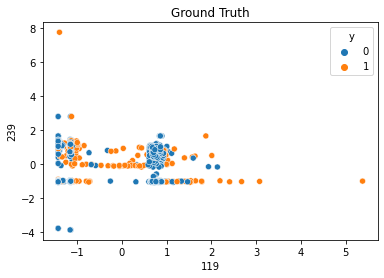

In [192]:
sns.scatterplot(x=df_train[119], y=df_train[239], hue='y', data=df_train);
plt.title('Ground Truth');

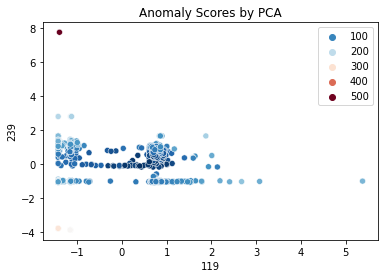

In [193]:
y_train_pred = clf_pca.labels_
y_train_scores = clf_pca.decision_scores_
sns.scatterplot(x=df_train[119], y=df_train[239], hue=y_train_scores, data=df_train, palette='RdBu_r');
plt.title('Anomaly Scores by PCA');

In [194]:
clf_pca.n_components_

2

In [195]:
from sklearn.decomposition import PCA

In [196]:
pca = PCA(2)
X_train_pca = pca.fit_transform(X_train)
X_train_pca = pd.DataFrame(X_train_pca)
X_train_pca.columns=['PC1','PC2']
X_train_pca.head()

,PC1,PC2
0,-16.893084,3.261716
1,9.096107,15.011179
2,6.768157,12.179503
3,-12.009298,-15.160351
4,5.706374,12.546378


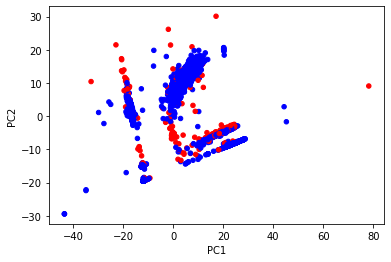

In [197]:
y_color = np.where(y_train==1,'red', 'blue')
X_train_pca.plot(kind='scatter', x='PC1', y='PC2',c=y_color);

In [198]:
pca.n_components_

2

In [199]:
pca.score(X_train)

9.67950630151596

In [200]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359
1902,0.0,-0.869200,-0.909627,-0.966453,-0.884794,-0.601738,-0.392601,-0.220232,-0.082638,0.035488,0.132492,0.211697,0.283515,0.333614,0.392287,0.434912,0.474707,0.505233,0.535084,0.563876,0.588112,0.609935,0.629909,0.649457,0.668496,0.685045,0.700047,0.714392,0.729964,0.744802,0.762105,0.780811,0.801560,0.821379,0.843851,0.867469,0.889391,0.912997,0.936116,0.958653,...,-1.033695,-1.033890,-1.035121,-1.035331,-1.034409,-1.035632,-1.035766,-1.035911,-1.035982,-1.037128,-1.037279,-1.037379,-1.037507,-1.037629,-1.037731,-1.037853,-1.037991,-1.038101,-1.038255,-1.039387,-1.038482,-1.039649,-1.039749,-1.039834,-1.039944,-1.040038,-1.040194,-1.040294,-1.041435,-1.041516,-1.041626,-1.041746,-1.041850,-1.041870,-1.042009,-1.042206,-1.042271,-1.042344,-1.042470,-1.042607
5656,0.0,1.474637,1.806623,1.874906,1.930649,1.973421,1.992813,2.001292,2.006986,2.000994,1.986485,1.977352,1.960132,1.945657,1.930332,1.917662,1.904602,1.893478,1.884133,1.873276,1.863865,1.857779,1.850241,1.843136,1.837535,1.829093,1.823144,1.817816,1.804940,1.720233,1.635089,1.558937,1.489460,1.426330,1.368960,1.316203,1.267292,1.221616,1.178298,1.137572,...,0.873317,0.872025,0.873595,0.875232,0.874022,0.872798,0.874501,0.876273,0.875228,0.877028,0.876128,0.877775,0.876849,0.878642,0.877731,0.879520,0.878772,0.877775,0.879592,0.878809,0.880621,0.879817,0.881842,0.880990,0.882926,0.882319,0.884222,0.883446,0.882634,0.884694,0.883956,0.885967,0.885328,0.887422,0.886592,0.885911,0.887948,0.887288,0.889370,0.888672
60,0.0,0.604725,0.938628,1.006688,1.030547,1.034626,1.032312,1.028204,1.027452,1.023296,1.020345,1.017344,1.010643,1.005087,0.994985,0.985131,0.979879,0.971991,0.965649,0.959448,0.954321,0.949860,0.943743,0.938927,0.935227,0.931870,0.927283,0.925593,0.925298,0.926234,0.928731,0.936026,0.943394,0.953146,0.964297,0.976683,0.989351,1.003885,1.014043,1.031049,...,0.672217,0.676547,0.678217,0.679947,0.681598,0.683226,0.676780,0.681384,0.683181,0.685064,0.686980,0.685986,0.685140,0.687015,0.688921,0.690791,0.692838,0.683728,0.688354,0.693100,0.692260,0.694249,0.696333,0.690101,0.694830,0.696998,0.698966,0.698255,0.697510,0.696904,0.698948,0.701016,0.703147,0.702580,0.696381,0.701181,0.703276,0.702673,0.704803,0.706872
2480,0.0,0.017125,-0.059430,-0.103535,-0.171621,-0.262319,-0.334611,-0.376659,-0.403741,-0.420501,-0.429168,-0.433811,-0.454167,-0.522646,-0.583012,-0.633932,-0.677716,-0.715628,-0.748724,-0.778021,-0.804102,-0.827194,-0.848196,-0.867053,-0.884153,-0.899812,-0.914163,-0.927571,-0.940357,-0.952756,-0.965038,-0.976927,-0.988489,-0.999730,-1.010564,-1.020942,-1.030808,-1.040056,-1.048827,-1.057018,...,-1.021298,-1.020468,-1.020674,-1.020890,-1.021008,-1.021208,-1.021349,-1.021500,-1.021579,-1.021702,-1.021859,-1.021967,-1.022102,-1.022231,-1.022339,-1.022467,-1.022610,-1.022727,-1.022888,-1.023001,-1.023127,-1.023276,-1.023381,-1.023472,-1.023588,-1.023686,-1.023848,-1.023953,-1.024079,-1.024166,-1.024282,-1.024406,-1.024515,-1.024541,-1.024686,-1.024888,-1.024958,-1.025036,-1.025167,-1.025309
3963,0.0,0.975669,1.332922,1.409442,1.444364,1.469401,1.475770,1.482567,1.482883,1.481308,1.474589,1.463917,1.452348,1.440031,1.427835,1.412351,1.402217,1.389058,1.377315,1.366372,1.356988,1.349367,1.340864,1.331944,1.324127,1.316766,1.310069,1.305841,1.301742,1.301353,1.303839,1.308640,1.315482,1.325007,1.337269,1.313234,1.265169,1.220311,1.177355,1.136897,...,0.622630,0.626989,0.628685,0.627688,0.629369,0.631025,0.632842,0.634720,0.636541,0.638444,0.640379,0.639408,0.641320,0.643214,0.645139,0.647028,0.646355,0.650931,0.650106,0.652135,0.654041,0.656044,0.655411,0.657377,0.659392,0.658844,0.660825,0.662851,0.664841,0.666966,0.666300,0.668377,0.670517,0.672679,0.671926,0.674015,0.676119,0.675524

## PCA nos dados originais - sem escalanamento

In [201]:
pca = PCA(0.99)

In [202]:
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca)
X_pca.columns=['PC1','PC2', 'PC3', 'PC4','PC5']
X_pca.head()

,PC1,PC2,PC3,PC4,PC5
0,5.198940,11.084099,-0.938199,-0.979237,0.783022
1,-16.833477,1.162147,-1.361895,0.074862,1.175544
2,5.632159,13.194415,-1.527948,-0.607818,0.728210
3,-17.112209,2.336979,-1.043117,-0.204674,1.706528
4,5.198831,13.575943,-2.816181,0.174944,0.570200


In [203]:
pca.n_components_

5

In [204]:
#split the data into train and test 
X_train_pca, X_test_pca, y_train,y_test = train_test_split(X_pca,y, test_size = 0.2, stratify=y, random_state=42 )

In [205]:
pca.explained_variance_ratio_

array([0.68448538, 0.26306308, 0.02701134, 0.01053532, 0.00553213])

In [206]:
a = pca.explained_variance_ratio_
a.sum()

0.9906272536893552

O quanto de informação cada componente representa da variância dos dados originais

## SVM, do PyOD, após o PCA

In [207]:
clf_ocsvm.fit(X_train_pca)

OCSVM(cache_size=200, coef0=0.0, contamination=0.172, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)

In [208]:
# Get the prediction labels of the training data
y_train_pred = clf_ocsvm.labels_  # binary labels (0: inliers, 1: outliers)

clf_name ='OCSVM'

# Outlier scores
y_train_scores = clf_ocsvm.decision_scores_ 
# Evaluate on the training data
evaluate_print(clf_name, y_train, y_train_scores)

OCSVM ROC:0.652, precision @ rank n:0.2686


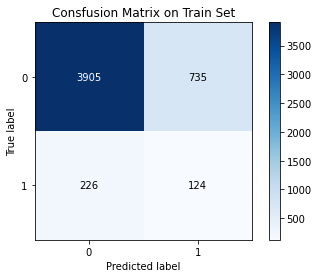

In [209]:
# plot the comfusion matrix  in the train set 

skplt.metrics.plot_confusion_matrix(y_train,y_train_pred, 
                                    normalize=False,
                                    title="Consfusion Matrix on Train Set")
plt.show()

Melhorou um pouco em todos os casos

In [210]:
# Outlier scores
y_test_scores = clf_ocsvm.decision_function(X_test_pca)
# Evaluate on the test data with pca
evaluate_print(clf_name, y_test, y_test_scores)

OCSVM ROC:0.6476, precision @ rank n:0.2273


In [211]:
# prediction for y test
y_test_pred = clf_ocsvm.predict(X_test_pca)

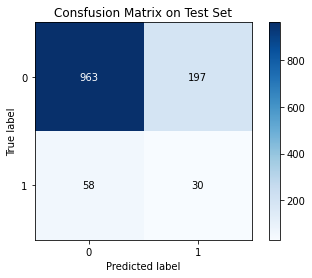

In [212]:
# plot the comfusion matrix in the test set 
skplt.metrics.plot_confusion_matrix(y_test,y_test_pred, normalize=False, title='Consfusion Matrix on Test Set') 
plt.show()

## Isolation Forest com 3 modelos - dados escalonados

In [213]:
from pyod.models.iforest import IForest

In [214]:
clf_IForest1 = IForest(behaviour="new", max_samples=200, contamination= contamination) 
clf_IForest1.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.172,
    max_features=1.0, max_samples=200, n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

In [215]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores = clf_IForest1.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

0   -0.019843
1   -0.060522
2   -0.093177
3    0.044981
4   -0.109579
dtype: float64

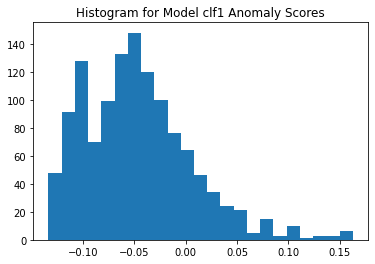

In [216]:
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model clf1 Anomaly Scores")
plt.show()

In [217]:
X_test_cluster = X_test.copy()
X_test_cluster['distance'] = y_test_scores
#acima de 0.06 será considerado anomalias
#Quanto maior o score do histograma e menor a frequência será caractarística de anomalias
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']<0.06, 0, 1)
X_test_cluster['cluster'].value_counts()

1    1026
0     222
Name: cluster, dtype: int64

In [218]:
X_test_cluster.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,distance
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.029413,-0.042206,-0.045341,-0.055739,-0.072196,-0.083114,-0.087973,-0.091760,-0.095313,-0.097526,-0.099218,-0.100263,-0.101803,-0.102848,-0.103446,-0.103961,-0.104372,-0.104629,-0.105263,-0.106204,-0.107019,-0.107952,-0.108797,-0.109646,-0.110844,-0.112147,-0.113248,-0.114513,-0.115704,-0.116794,-0.117648,-0.118459,-0.118524,-0.11836,-0.117654,-0.117100,-0.116599,-0.115890,-0.115037,...,0.038503,0.038808,0.038976,0.039260,0.039651,0.040042,0.040142,0.040550,0.040776,0.040991,0.041122,0.041271,0.041537,0.041662,0.041844,0.042486,0.042753,0.042995,0.043237,0.043368,0.043613,0.043876,0.044047,0.044107,0.043948,0.044136,0.044217,0.044510,0.044053,0.044417,0.044609,0.044842,0.044261,0.044923,0.044879,0.045194,0.045199,0.045198,0.045246,-0.053897
1,0.0,-0.017737,-0.000569,0.003998,0.012095,0.023907,0.032946,0.041101,0.047941,0.052853,0.056668,0.059596,0.061657,0.063302,0.064605,0.065653,0.066681,0.067576,0.068325,0.069115,0.069819,0.070484,0.071154,0.071807,0.072462,0.073107,0.073780,0.074379,0.075031,0.075462,0.076021,0.076959,0.078160,0.079287,0.07981,0.080154,0.080547,0.080899,0.081264,0.081573,...,-0.049765,-0.049725,-0.049762,-0.049604,-0.049690,-0.049677,-0.049646,-0.049717,-0.049691,-0.049617,-0.049611,-0.049642,-0.049447,-0.049437,-0.049366,-0.049556,-0.049309,-0.049245,-0.049197,-0.049246,-0.049149,-0.049224,-0.049046,-0.048993,-0.049036,-0.048885,-0.048920,-0.048898,-0.048929,-0.048905,-0.048861,-0.048813,-0.048736,-0.048816,-0.048648,-0.048553,-0.048447,-0.048322,-0.048180,0.105582


In [219]:
X_test_cluster.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,distance,cluster
1935,0.0,0.821383,0.612787,0.468800,0.347851,0.230350,0.134675,0.072164,0.024900,-0.006977,-0.029543,-0.042269,-0.049397,-0.051437,-0.042699,-0.026286,-0.010778,0.001859,0.012818,0.023074,0.031640,0.039130,0.045292,0.051399,0.056541,0.060536,0.064194,0.067618,0.071666,0.076220,0.080981,0.087321,0.093343,0.100631,0.109358,0.118078,0.126867,0.135920,0.145534,0.154784,...,0.364512,0.371892,0.376469,0.381009,0.382946,0.387676,0.392367,0.397118,0.399147,0.403781,0.408530,0.410524,0.415284,0.417272,0.422140,0.424087,0.428816,0.430923,0.432921,0.437729,0.439893,0.444672,0.446762,0.448996,0.453774,0.455873,0.457937,0.462846,0.464967,0.469826,0.469302,0.474245,0.476280,0.478419,0.480585,0.482764,0.484952,0.489799,NaN,1
2619,0.0,0.598160,0.918092,0.970476,0.976365,0.960272,0.939235,0.941678,0.946704,0.963643,0.972402,0.977447,0.977226,0.974597,0.969348,0.964267,0.960192,0.955079,0.949544,0.946076,0.940446,0.937213,0.932477,0.928021,0.923785,0.920286,0.915563,0.912640,0.912347,0.912333,0.915313,0.920407,0.926702,0.935963,0.946345,0.958151,0.969978,0.983252,0.996212,1.009170,...,0.780033,0.781716,0.780559,0.782133,0.783879,0.785691,0.784691,0.786531,0.785666,0.787360,0.789211,0.788303,0.790167,0.789258,0.791274,0.793050,0.792169,0.794148,0.793265,0.795220,0.794544,0.796454,0.795693,0.797834,0.797043,0.796298,0.798239,0.797603,0.799614,0.798931,0.801035,0.800437,0.802356,0.801696,0.801044,0.803125,0.802515,0.801842,NaN,1
4577,0.0,-0.869200,-0.909627,-0.962920,-0.666033,-0.470057,-0.339484,-0.221937,-0.134331,-0.046745,0.016276,0.075497,0.123466,0.165226,0.199577,0.228655,0.260566,0.282054,0.305339,0.325040,0.343530,0.360085,0.375623,0.390525,0.402749,0.416942,0.429684,0.442927,0.454904,0.467608,0.482526,0.498788,0.515125,0.533566,0.553223,0.571940,0.593051,0.612387,0.633926,0.652936,...,-1.030993,-1.031205,-1.032348,-1.032541,-1.032677,-1.032823,-1.032896,-1.033014,-1.034195,-1.034296,-1.034426,-1.034550,-1.034653,-1.034775,-1.034915,-1.036051,-1.036206,-1.036314,-1.036435,-1.036579,-1.036680,-1.036766,-1.036877,-1.036972,-1.038151,-1.038251,-1.038372,-1.038454,-1.038565,-1.038686,-1.038791,-1.038812,-1.038952,-1.039150,-1.039216,-1.039290,-1.039416,-1.039555,NaN,1
763,0.0,0.250195,0.293792,0.149953,0.019372,-0.109069,-0.204010,-0.267970,-0.308655,-0.336583,-0.355130,-0.368600,-0.379293,-0.391447,-0.398421,-0.400650,-0.400057,-0.397771,-0.392604,-0.385093,-0.376194,-0.363468,-0.349548,-0.336101,-0.322886,-0.311593,-0.301068,-0.291335,-0.282165,-0.273774,-0.265088,-0.256397,-0.247555,-0.238358,-0.229174,-0.219553,-0.210342,-0.200210,-0.190605,-0.181175,...,0.119602,0.118846,0.118072,0.117256,0.119319,0.115929,0.118014,0.117399,0.116796,0.116097,0.115489,0.117608,0.117019,0.116400,0.206128,0.235506,0.259434,0.277986,0.288238,0.295824,0.300761,0.302868,0.307734,0.312732,0.314832,0.319703,0.321816,0.326767,0.331652,0.333832,0.338784,0.341050,0.343133,0.345305,0.350229,0.352448,0.357384,0.359554,-0.068766,0
247,0.0,-0.869200,-0.858972,-0.318160,-0.123534,-0.042094,0.018694,0.068328,0.124136,0.160523,0.202282,0.233159,0.263163,0.282105,0.304264,0.322643,0.336899,0.352146,0.365651,0.376664,0.388697,0.396761,0.407543,0.416444,0.424280,0.434792,0.441974,0.451599,0.459150,0.469358,0.479522,0.493419,0.506636,0.522266,0.537835,0.555567,0.572439,0.590100,0.609150,0.626496,...,-1.038216,-1.038425,-1.038533,-1.038723,-1.038855,-1.038999,-1.039069,-1.039185,-1.039335,-1.039434,-1.039561,-1.039682,-1.039783,-1.039904,-1.040041,-1.040151,-1.040304,-1.040411,-1.040530,-1.040673,-1.040772,-1.040856,-1.040966,-1.041060,-1.041216,-1.041315,-1.041435,-1.041516,-1.041626,-1.041746,-1.041850,-1.041870,-1.042009,-1.042206,-1.042271,-1.042344,-1.042470,-1.042607,-0.095978,0


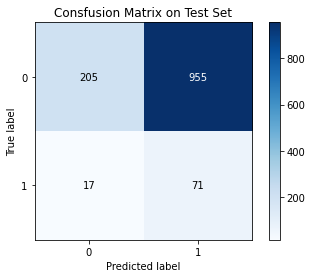

In [220]:
# plot the comfusion matrix  in the test set 

skplt.metrics.plot_confusion_matrix(y_test,X_test_cluster['cluster'], 
                                    normalize=False,
                                    title="Consfusion Matrix on Test Set")
plt.show()

Segundo modelo com Isolation Forest

In [221]:
clf2 = IForest(behaviour="new", max_samples=100, contamination=contamination) 
clf2.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.172,
    max_features=1.0, max_samples=100, n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

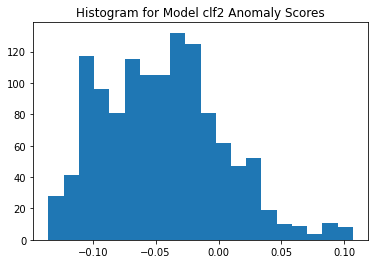

In [222]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf2.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model clf2 Anomaly Scores")
plt.show()

In [223]:
X_test_cluster = X_test.copy()
X_test_cluster['distance'] = y_test_scores
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']<0.05, 0, 1)
X_test_cluster['cluster'].value_counts()

1    1024
0     224
Name: cluster, dtype: int64

In [224]:
X_test_cluster.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,distance
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.039737,-0.032140,-0.035873,-0.044595,-0.060049,-0.070335,-0.074704,-0.078110,-0.081439,-0.083485,-0.085104,-0.086121,-0.087653,-0.088712,-0.089322,-0.089873,-0.090307,-0.090571,-0.091222,-0.092173,-0.093001,-0.093943,-0.094799,-0.095655,-0.096858,-0.098156,-0.099234,-0.100476,-0.101605,-0.102602,-0.103350,-0.104026,-0.103943,-0.103613,-0.10275,-0.102151,-0.101732,-0.101097,-0.100315,...,0.031005,0.031313,0.031489,0.031775,0.032172,0.032569,0.032662,0.033089,0.033311,0.033535,0.033674,0.033819,0.034106,0.034228,0.034419,0.035053,0.035340,0.035602,0.035828,0.035980,0.036220,0.036492,0.037037,0.037240,0.037191,0.037460,0.037611,0.037936,0.037530,0.037913,0.038138,0.038403,0.037863,0.038529,0.038518,0.038853,0.038893,0.038902,0.038972,-0.050061
1,0.0,-0.020087,-0.002689,0.002024,0.009789,0.021437,0.030377,0.038451,0.045228,0.050108,0.053898,0.056819,0.058880,0.060529,0.061840,0.062893,0.063933,0.064835,0.065587,0.066384,0.067093,0.067764,0.068440,0.069098,0.069757,0.070407,0.071082,0.071680,0.072330,0.072751,0.073293,0.074211,0.075387,0.076484,0.076971,0.07728,0.077663,0.078033,0.078413,0.078736,...,-0.048297,-0.048258,-0.048297,-0.048140,-0.048228,-0.048217,-0.048185,-0.048261,-0.048235,-0.048163,-0.048159,-0.048189,-0.048000,-0.047989,-0.047920,-0.048110,-0.047868,-0.047808,-0.047756,-0.047811,-0.047713,-0.047790,-0.047694,-0.047673,-0.047739,-0.047606,-0.047657,-0.047643,-0.047683,-0.047665,-0.047628,-0.047587,-0.047518,-0.047600,-0.047439,-0.047349,-0.047250,-0.047127,-0.046990,0.085610


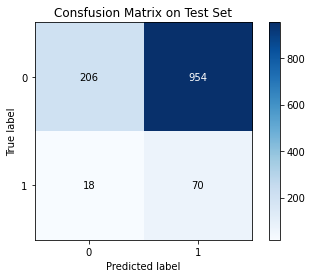

In [225]:
# plot the comfusion matrix  in the test set 

skplt.metrics.plot_confusion_matrix(y_test,X_test_cluster['cluster'], 
                                    normalize=False,
                                    title="Consfusion Matrix on Test Set")
plt.show()

Terceiro modelo do Isolation Forest

In [226]:
clf3 = IForest(behaviour="new", max_samples=1000, contamination=contamination) 
clf3.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.172,
    max_features=1.0, max_samples=1000, n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

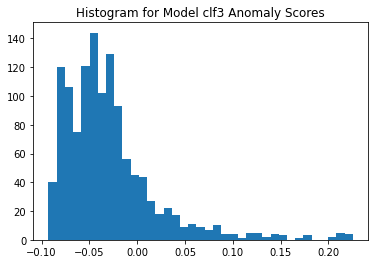

In [227]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf3.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model clf3 Anomaly Scores")
plt.show()

In [228]:
X_test_cluster = X_test.copy()
X_test_cluster['distance'] = y_test_scores
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']<0.09, 0, 1)
X_test_cluster['cluster'].value_counts()

1    1026
0     222
Name: cluster, dtype: int64

In [229]:
X_test_cluster.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,distance,cluster
1935,0.0,0.821383,0.612787,0.468800,0.347851,0.230350,0.134675,0.072164,0.024900,-0.006977,-0.029543,-0.042269,-0.049397,-0.051437,-0.042699,-0.026286,-0.010778,0.001859,0.012818,0.023074,0.031640,0.039130,0.045292,0.051399,0.056541,0.060536,0.064194,0.067618,0.071666,0.076220,0.080981,0.087321,0.093343,0.100631,0.109358,0.118078,0.126867,0.135920,0.145534,0.154784,...,0.364512,0.371892,0.376469,0.381009,0.382946,0.387676,0.392367,0.397118,0.399147,0.403781,0.408530,0.410524,0.415284,0.417272,0.422140,0.424087,0.428816,0.430923,0.432921,0.437729,0.439893,0.444672,0.446762,0.448996,0.453774,0.455873,0.457937,0.462846,0.464967,0.469826,0.469302,0.474245,0.476280,0.478419,0.480585,0.482764,0.484952,0.489799,NaN,1
2619,0.0,0.598160,0.918092,0.970476,0.976365,0.960272,0.939235,0.941678,0.946704,0.963643,0.972402,0.977447,0.977226,0.974597,0.969348,0.964267,0.960192,0.955079,0.949544,0.946076,0.940446,0.937213,0.932477,0.928021,0.923785,0.920286,0.915563,0.912640,0.912347,0.912333,0.915313,0.920407,0.926702,0.935963,0.946345,0.958151,0.969978,0.983252,0.996212,1.009170,...,0.780033,0.781716,0.780559,0.782133,0.783879,0.785691,0.784691,0.786531,0.785666,0.787360,0.789211,0.788303,0.790167,0.789258,0.791274,0.793050,0.792169,0.794148,0.793265,0.795220,0.794544,0.796454,0.795693,0.797834,0.797043,0.796298,0.798239,0.797603,0.799614,0.798931,0.801035,0.800437,0.802356,0.801696,0.801044,0.803125,0.802515,0.801842,NaN,1
4577,0.0,-0.869200,-0.909627,-0.962920,-0.666033,-0.470057,-0.339484,-0.221937,-0.134331,-0.046745,0.016276,0.075497,0.123466,0.165226,0.199577,0.228655,0.260566,0.282054,0.305339,0.325040,0.343530,0.360085,0.375623,0.390525,0.402749,0.416942,0.429684,0.442927,0.454904,0.467608,0.482526,0.498788,0.515125,0.533566,0.553223,0.571940,0.593051,0.612387,0.633926,0.652936,...,-1.030993,-1.031205,-1.032348,-1.032541,-1.032677,-1.032823,-1.032896,-1.033014,-1.034195,-1.034296,-1.034426,-1.034550,-1.034653,-1.034775,-1.034915,-1.036051,-1.036206,-1.036314,-1.036435,-1.036579,-1.036680,-1.036766,-1.036877,-1.036972,-1.038151,-1.038251,-1.038372,-1.038454,-1.038565,-1.038686,-1.038791,-1.038812,-1.038952,-1.039150,-1.039216,-1.039290,-1.039416,-1.039555,NaN,1
763,0.0,0.250195,0.293792,0.149953,0.019372,-0.109069,-0.204010,-0.267970,-0.308655,-0.336583,-0.355130,-0.368600,-0.379293,-0.391447,-0.398421,-0.400650,-0.400057,-0.397771,-0.392604,-0.385093,-0.376194,-0.363468,-0.349548,-0.336101,-0.322886,-0.311593,-0.301068,-0.291335,-0.282165,-0.273774,-0.265088,-0.256397,-0.247555,-0.238358,-0.229174,-0.219553,-0.210342,-0.200210,-0.190605,-0.181175,...,0.119602,0.118846,0.118072,0.117256,0.119319,0.115929,0.118014,0.117399,0.116796,0.116097,0.115489,0.117608,0.117019,0.116400,0.206128,0.235506,0.259434,0.277986,0.288238,0.295824,0.300761,0.302868,0.307734,0.312732,0.314832,0.319703,0.321816,0.326767,0.331652,0.333832,0.338784,0.341050,0.343133,0.345305,0.350229,0.352448,0.357384,0.359554,-0.044290,0
247,0.0,-0.869200,-0.858972,-0.318160,-0.123534,-0.042094,0.018694,0.068328,0.124136,0.160523,0.202282,0.233159,0.263163,0.282105,0.304264,0.322643,0.336899,0.352146,0.365651,0.376664,0.388697,0.396761,0.407543,0.416444,0.424280,0.434792,0.441974,0.451599,0.459150,0.469358,0.479522,0.493419,0.506636,0.522266,0.537835,0.555567,0.572439,0.590100,0.609150,0.626496,...,-1.038216,-1.038425,-1.038533,-1.038723,-1.038855,-1.038999,-1.039069,-1.039185,-1.039335,-1.039434,-1.039561,-1.039682,-1.039783,-1.039904,-1.040041,-1.040151,-1.040304,-1.040411,-1.040530,-1.040673,-1.040772,-1.040856,-1.040966,-1.041060,-1.041216,-1.041315,-1.041435,-1.041516,-1.041626,-1.041746,-1.041850,-1.041870,-1.042009,-1.042206,-1.042271,-1.042344,-1.042470,-1.042607,-0.072811,0


In [230]:
y_test.value_counts()

0    1160
1      88
Name: 361, dtype: int64

In [231]:
X_test_cluster.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,distance
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.042351,-0.030050,-0.033218,-0.042978,-0.058935,-0.069486,-0.074157,-0.077834,-0.081390,-0.083671,-0.085490,-0.086675,-0.088305,-0.089515,-0.090229,-0.090877,-0.091375,-0.091724,-0.092444,-0.093462,-0.094367,-0.095375,-0.096298,-0.097211,-0.098476,-0.099838,-0.100988,-0.102297,-0.103496,-0.104583,-0.105423,-0.106199,-0.106217,-0.105993,-0.105239,-0.104755,-0.104458,-0.103945,-0.103283,...,0.036211,0.036526,0.036708,0.036988,0.037392,0.037797,0.037893,0.038314,0.038541,0.038770,0.038914,0.039064,0.039344,0.039470,0.039665,0.040307,0.040587,0.040843,0.041086,0.041230,0.041475,0.041752,0.041923,0.041984,0.041838,0.042027,0.042120,0.042414,0.041971,0.042335,0.042540,0.042786,0.042206,0.042868,0.042837,0.043152,0.043170,0.043170,0.043219,-0.037649
1,0.0,-0.020536,-0.003199,0.001375,0.009333,0.021037,0.029997,0.038112,0.044928,0.049841,0.053670,0.056626,0.058717,0.060381,0.061720,0.062793,0.063850,0.064764,0.065532,0.066341,0.067062,0.067746,0.068433,0.069102,0.069771,0.070431,0.071116,0.071726,0.072387,0.072821,0.073379,0.074314,0.075507,0.076625,0.077134,0.077468,0.077876,0.078272,0.078680,0.079030,...,-0.049269,-0.049231,-0.049271,-0.049112,-0.049201,-0.049191,-0.049160,-0.049233,-0.049208,-0.049136,-0.049134,-0.049164,-0.048973,-0.048963,-0.048895,-0.049085,-0.048841,-0.048779,-0.048731,-0.048783,-0.048686,-0.048764,-0.048587,-0.048533,-0.048579,-0.048428,-0.048466,-0.048445,-0.048478,-0.048455,-0.048414,-0.048368,-0.048291,-0.048371,-0.048206,-0.048111,-0.048008,-0.047883,-0.047741,0.152986


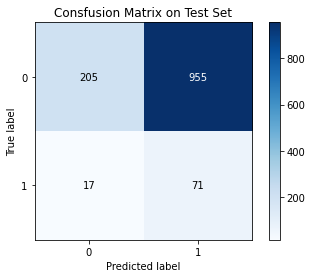

In [232]:
# plot the comfusion matrix  in the test set 

skplt.metrics.plot_confusion_matrix(y_test,X_test_cluster['cluster'], 
                                    normalize=False,
                                    title="Consfusion Matrix on Test Set")
plt.show()

Average Method

In [233]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer

# The predictions of the training data can be obtained by clf.decision_scores_.
# It is already generated during the model building process.
train_scores = pd.DataFrame({'clf1': clf_IForest1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_
                            })

# The predictions of the test data need to be predicted using clf.decision_function(X_test)
test_scores  = pd.DataFrame({'clf1': clf_IForest1.decision_function(X_test),
                             'clf2': clf2.decision_function(X_test),
                             'clf3': clf3.decision_function(X_test) 
                            })

In [234]:
train_scores.head()

,clf1,clf2,clf3
0,-0.074472,-0.058299,-0.049965
1,-0.028831,-0.026252,-0.019473
2,-0.043987,-0.062003,-0.029477
3,-0.000198,0.007210,-0.022906
4,-0.066985,-0.053233,-0.041949


In [235]:
# Although we did standardization before, it was for the variables.
# Now we do the standardization for the decision scores
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)
train_scores_norm.shape

(4990, 3)

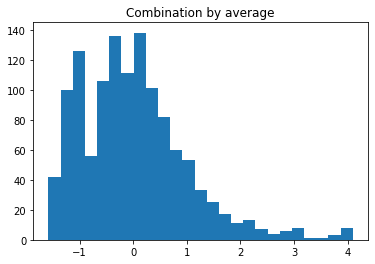

In [236]:
# Combination by average
y_by_average = average(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [237]:
df_test = X_test.copy()
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<2, 0, 1)
df_test['y_by_average_cluster'].value_counts()

0    1194
1      54
Name: y_by_average_cluster, dtype: int64

In [238]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,y_by_average_score,y_by_average_cluster
1935,0.0,0.821383,0.612787,0.468800,0.347851,0.230350,0.134675,0.072164,0.024900,-0.006977,-0.029543,-0.042269,-0.049397,-0.051437,-0.042699,-0.026286,-0.010778,0.001859,0.012818,0.023074,0.031640,0.039130,0.045292,0.051399,0.056541,0.060536,0.064194,0.067618,0.071666,0.076220,0.080981,0.087321,0.093343,0.100631,0.109358,0.118078,0.126867,0.135920,0.145534,0.154784,...,0.364512,0.371892,0.376469,0.381009,0.382946,0.387676,0.392367,0.397118,0.399147,0.403781,0.408530,0.410524,0.415284,0.417272,0.422140,0.424087,0.428816,0.430923,0.432921,0.437729,0.439893,0.444672,0.446762,0.448996,0.453774,0.455873,0.457937,0.462846,0.464967,0.469826,0.469302,0.474245,0.476280,0.478419,0.480585,0.482764,0.484952,0.489799,0.564181,0
2619,0.0,0.598160,0.918092,0.970476,0.976365,0.960272,0.939235,0.941678,0.946704,0.963643,0.972402,0.977447,0.977226,0.974597,0.969348,0.964267,0.960192,0.955079,0.949544,0.946076,0.940446,0.937213,0.932477,0.928021,0.923785,0.920286,0.915563,0.912640,0.912347,0.912333,0.915313,0.920407,0.926702,0.935963,0.946345,0.958151,0.969978,0.983252,0.996212,1.009170,...,0.780033,0.781716,0.780559,0.782133,0.783879,0.785691,0.784691,0.786531,0.785666,0.787360,0.789211,0.788303,0.790167,0.789258,0.791274,0.793050,0.792169,0.794148,0.793265,0.795220,0.794544,0.796454,0.795693,0.797834,0.797043,0.796298,0.798239,0.797603,0.799614,0.798931,0.801035,0.800437,0.802356,0.801696,0.801044,0.803125,0.802515,0.801842,-0.332163,0
4577,0.0,-0.869200,-0.909627,-0.962920,-0.666033,-0.470057,-0.339484,-0.221937,-0.134331,-0.046745,0.016276,0.075497,0.123466,0.165226,0.199577,0.228655,0.260566,0.282054,0.305339,0.325040,0.343530,0.360085,0.375623,0.390525,0.402749,0.416942,0.429684,0.442927,0.454904,0.467608,0.482526,0.498788,0.515125,0.533566,0.553223,0.571940,0.593051,0.612387,0.633926,0.652936,...,-1.030993,-1.031205,-1.032348,-1.032541,-1.032677,-1.032823,-1.032896,-1.033014,-1.034195,-1.034296,-1.034426,-1.034550,-1.034653,-1.034775,-1.034915,-1.036051,-1.036206,-1.036314,-1.036435,-1.036579,-1.036680,-1.036766,-1.036877,-1.036972,-1.038151,-1.038251,-1.038372,-1.038454,-1.038565,-1.038686,-1.038791,-1.038812,-1.038952,-1.039150,-1.039216,-1.039290,-1.039416,-1.039555,-0.909021,0
763,0.0,0.250195,0.293792,0.149953,0.019372,-0.109069,-0.204010,-0.267970,-0.308655,-0.336583,-0.355130,-0.368600,-0.379293,-0.391447,-0.398421,-0.400650,-0.400057,-0.397771,-0.392604,-0.385093,-0.376194,-0.363468,-0.349548,-0.336101,-0.322886,-0.311593,-0.301068,-0.291335,-0.282165,-0.273774,-0.265088,-0.256397,-0.247555,-0.238358,-0.229174,-0.219553,-0.210342,-0.200210,-0.190605,-0.181175,...,0.119602,0.118846,0.118072,0.117256,0.119319,0.115929,0.118014,0.117399,0.116796,0.116097,0.115489,0.117608,0.117019,0.116400,0.206128,0.235506,0.259434,0.277986,0.288238,0.295824,0.300761,0.302868,0.307734,0.312732,0.314832,0.319703,0.321816,0.326767,0.331652,0.333832,0.338784,0.341050,0.343133,0.345305,0.350229,0.352448,0.357384,0.359554,1.772399,0
247,0.0,-0.869200,-0.858972,-0.318160,-0.123534,-0.042094,0.018694,0.068328,0.124136,0.160523,0.202282,0.233159,0.263163,0.282105,0.304264,0.322643,0.336899,0.352146,0.365651,0.376664,0.388697,0.396761,0.407543,0.416444,0.424280,0.434792,0.441974,0.451599,0.459150,0.469358,0.479522,0.493419,0.506636,0.522266,0.537835,0.555567,0.572439,0.590100,0.609150,0.626496,...,-1.038216,-1.038425,-1.038533,-1.038723,-1.038855,-1.038999,-1.039069,-1.039185,-1.039335,-1.039434,-1.039561,-1.039682,-1.039783,-1.039904,-1.040041,-1.040151,-1.040304,-1.040411,-1.040530,-1.040673,-1.040772,-1.040856,-1.040966,-1.041060,-1.041216,-1.041315,-1.041435,-1.041516,-1.041626,-1.041746,-1.041850,-1.041870,-1.042009,-1.042206,-1.042271,-1.042344,-1.042

In [239]:
df_test.groupby('y_by_average_cluster').mean().round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,y_by_average_score
y_by_average_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,-0.01,-0.01,-0.00,0.01,0.02,0.02,0.03,0.04,0.04,0.05,0.05,0.05,0.05,0.05,0.05,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,...,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.12
1,0.0,-0.00,-0.05,-0.08,-0.13,-0.20,-0.26,-0.31,-0.34,-0.35,-0.36,-0.37,-0.37,-0.38,-0.38,-0.38,-0.38,-0.38,-0.39,-0.39,-0.39,-0.40,-0.40,-0.40,-0.41,-0.41,-0.41,-0.42,-0.42,-0.43,-0.44,-0.45,-0.46,-0.47,-0.47,-0.48,-0.49,-0.49,-0.50,-0.50,...,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,2.84


In [240]:
clf_name = 'IForest'

In [241]:
# evaluate and print the results
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_by_average)


On Test Data:
IForest ROC:0.7079, precision @ rank n:0.2159


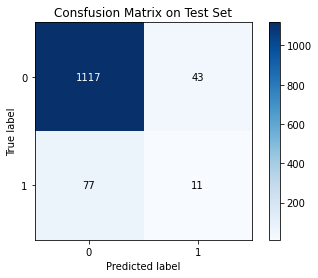

In [242]:
# plot the comfusion matrix  in the test set 

skplt.metrics.plot_confusion_matrix(y_test,df_test['y_by_average_cluster'], 
                                    normalize=False,
                                    title="Consfusion Matrix on Test Set")
plt.show()

Maximum of Maximum Method

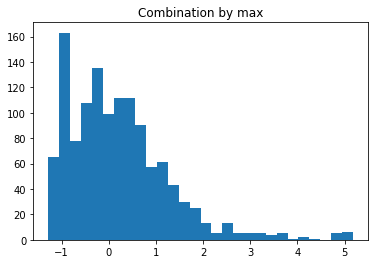

In [243]:
# Combination by max
y_by_maximization = maximization(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

In [244]:
df_test = X_test.copy()
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<2, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()

0    1184
1      64
Name: y_by_maximization_cluster, dtype: int64

In [245]:
df_test.groupby('y_by_maximization_cluster').mean().round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,y_by_maximization_score
y_by_maximization_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,-0.01,-0.01,-0.00,0.01,0.02,0.03,0.04,0.04,0.05,0.05,0.05,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.08,0.08,0.08,0.08,0.08,...,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,0.04
1,0.0,0.04,-0.03,-0.07,-0.13,-0.20,-0.27,-0.31,-0.34,-0.36,-0.37,-0.38,-0.38,-0.39,-0.39,-0.40,-0.40,-0.40,-0.41,-0.41,-0.42,-0.42,-0.43,-0.43,-0.43,-0.44,-0.44,-0.45,-0.45,-0.46,-0.47,-0.48,-0.49,-0.50,-0.51,-0.52,-0.52,-0.53,-0.53,-0.54,...,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.31,0.31,0.31,0.31,0.31,3.20


In [246]:
df_test.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,y_by_maximization_score,y_by_maximization_cluster
1935,0.0,0.821383,0.612787,0.468800,0.347851,0.230350,0.134675,0.072164,0.024900,-0.006977,-0.029543,-0.042269,-0.049397,-0.051437,-0.042699,-0.026286,-0.010778,0.001859,0.012818,0.023074,0.031640,0.039130,0.045292,0.051399,0.056541,0.060536,0.064194,0.067618,0.071666,0.076220,0.080981,0.087321,0.093343,0.100631,0.109358,0.118078,0.126867,0.135920,0.145534,0.154784,...,0.364512,0.371892,0.376469,0.381009,0.382946,0.387676,0.392367,0.397118,0.399147,0.403781,0.408530,0.410524,0.415284,0.417272,0.422140,0.424087,0.428816,0.430923,0.432921,0.437729,0.439893,0.444672,0.446762,0.448996,0.453774,0.455873,0.457937,0.462846,0.464967,0.469826,0.469302,0.474245,0.476280,0.478419,0.480585,0.482764,0.484952,0.489799,0.749235,0
2619,0.0,0.598160,0.918092,0.970476,0.976365,0.960272,0.939235,0.941678,0.946704,0.963643,0.972402,0.977447,0.977226,0.974597,0.969348,0.964267,0.960192,0.955079,0.949544,0.946076,0.940446,0.937213,0.932477,0.928021,0.923785,0.920286,0.915563,0.912640,0.912347,0.912333,0.915313,0.920407,0.926702,0.935963,0.946345,0.958151,0.969978,0.983252,0.996212,1.009170,...,0.780033,0.781716,0.780559,0.782133,0.783879,0.785691,0.784691,0.786531,0.785666,0.787360,0.789211,0.788303,0.790167,0.789258,0.791274,0.793050,0.792169,0.794148,0.793265,0.795220,0.794544,0.796454,0.795693,0.797834,0.797043,0.796298,0.798239,0.797603,0.799614,0.798931,0.801035,0.800437,0.802356,0.801696,0.801044,0.803125,0.802515,0.801842,-0.248565,0
4577,0.0,-0.869200,-0.909627,-0.962920,-0.666033,-0.470057,-0.339484,-0.221937,-0.134331,-0.046745,0.016276,0.075497,0.123466,0.165226,0.199577,0.228655,0.260566,0.282054,0.305339,0.325040,0.343530,0.360085,0.375623,0.390525,0.402749,0.416942,0.429684,0.442927,0.454904,0.467608,0.482526,0.498788,0.515125,0.533566,0.553223,0.571940,0.593051,0.612387,0.633926,0.652936,...,-1.030993,-1.031205,-1.032348,-1.032541,-1.032677,-1.032823,-1.032896,-1.033014,-1.034195,-1.034296,-1.034426,-1.034550,-1.034653,-1.034775,-1.034915,-1.036051,-1.036206,-1.036314,-1.036435,-1.036579,-1.036680,-1.036766,-1.036877,-1.036972,-1.038151,-1.038251,-1.038372,-1.038454,-1.038565,-1.038686,-1.038791,-1.038812,-1.038952,-1.039150,-1.039216,-1.039290,-1.039416,-1.039555,-0.817053,0
763,0.0,0.250195,0.293792,0.149953,0.019372,-0.109069,-0.204010,-0.267970,-0.308655,-0.336583,-0.355130,-0.368600,-0.379293,-0.391447,-0.398421,-0.400650,-0.400057,-0.397771,-0.392604,-0.385093,-0.376194,-0.363468,-0.349548,-0.336101,-0.322886,-0.311593,-0.301068,-0.291335,-0.282165,-0.273774,-0.265088,-0.256397,-0.247555,-0.238358,-0.229174,-0.219553,-0.210342,-0.200210,-0.190605,-0.181175,...,0.119602,0.118846,0.118072,0.117256,0.119319,0.115929,0.118014,0.117399,0.116796,0.116097,0.115489,0.117608,0.117019,0.116400,0.206128,0.235506,0.259434,0.277986,0.288238,0.295824,0.300761,0.302868,0.307734,0.312732,0.314832,0.319703,0.321816,0.326767,0.331652,0.333832,0.338784,0.341050,0.343133,0.345305,0.350229,0.352448,0.357384,0.359554,1.886590,0
247,0.0,-0.869200,-0.858972,-0.318160,-0.123534,-0.042094,0.018694,0.068328,0.124136,0.160523,0.202282,0.233159,0.263163,0.282105,0.304264,0.322643,0.336899,0.352146,0.365651,0.376664,0.388697,0.396761,0.407543,0.416444,0.424280,0.434792,0.441974,0.451599,0.459150,0.469358,0.479522,0.493419,0.506636,0.522266,0.537835,0.555567,0.572439,0.590100,0.609150,0.626496,...,-1.038216,-1.038425,-1.038533,-1.038723,-1.038855,-1.038999,-1.039069,-1.039185,-1.039335,-1.039434,-1.039561,-1.039682,-1.039783,-1.039904,-1.040041,-1.040151,-1.040304,-1.040411,-1.040530,-1.040673,-1.040772,-1.040856,-1.040966,-1.041060,-1.041216,-1.041315,-1.041435,-1.041516,-1.041626,-1.041746,-1.041850,-1.041870,-1.042009,-1.042206,-1.042271,-1.042

In [247]:
# evaluate and print the results
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_by_maximization)


On Test Data:
IForest ROC:0.7148, precision @ rank n:0.2273


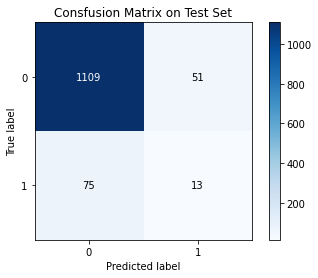

In [248]:
# plot the comfusion matrix  in the test set 

skplt.metrics.plot_confusion_matrix(y_test,df_test['y_by_maximization_cluster'], 
                                    normalize=False,
                                    title="Consfusion Matrix on Test Set")
plt.show()

## Isolation Forest - dados escalonados

In [249]:
# train IForest detector
clf_name = 'IForest'
clf = IForest(behaviour="new", contamination= contamination)
clf.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.172,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

In [250]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

In [251]:
# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

In [252]:
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
IForest ROC:0.7081, precision @ rank n:0.2657

On Test Data:
IForest ROC:0.6846, precision @ rank n:0.2159


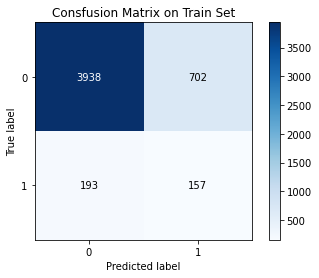

In [253]:
# plot the comfusion matrix  in the train set 

skplt.metrics.plot_confusion_matrix(y_train,y_train_pred, 
                                    normalize=False,
                                    title="Consfusion Matrix on Train Set")
plt.show()

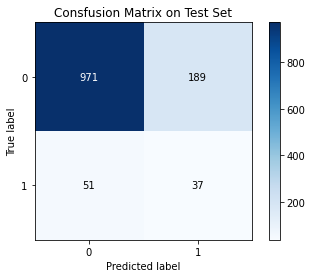

In [254]:
# plot the comfusion matrix in the test set 
skplt.metrics.plot_confusion_matrix(y_test,y_test_pred, normalize=False, title='Consfusion Matrix on Test Set') 
plt.show()

## Isolation Forest com PCA nos dados

In [255]:
# train IForest detector
clf_name = 'IForest'
clf = IForest(behaviour="new", contamination=contamination)
clf.fit(X_train_pca)

IForest(behaviour='new', bootstrap=False, contamination=0.172,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

In [256]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

In [257]:
# get the prediction on the test data
y_test_pred = clf.predict(X_test_pca)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test_pca)  # outlier scores

In [258]:
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
IForest ROC:0.6443, precision @ rank n:0.16

On Test Data:
IForest ROC:0.6331, precision @ rank n:0.1136


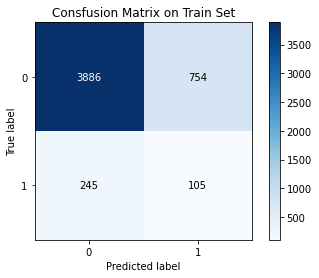

In [259]:
# plot the comfusion matrix  in the train set 

skplt.metrics.plot_confusion_matrix(y_train,y_train_pred, 
                                    normalize=False,
                                    title="Consfusion Matrix on Train Set")
plt.show()

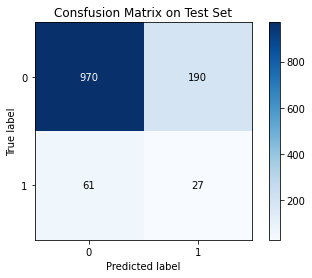

In [260]:
# plot the comfusion matrix in the test set 
skplt.metrics.plot_confusion_matrix(y_test,y_test_pred, normalize=False, title='Consfusion Matrix on Test Set') 
plt.show()

## Autoenconder - dados escalonados

In [261]:
from pyod.models.auto_encoder import AutoEncoder

In [262]:
# train AutoEncoder detector
clf_name = 'AutoEncoder'
clf = AutoEncoder(epochs=epochs, contamination=contamination)
clf.fit(X_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 360)               129960    
_________________________________________________________________
dropout (Dropout)            (None, 360)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 360)               129960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 360)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                23104     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

AutoEncoder(batch_size=32, contamination=0.172, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[64, 32, 32, 64],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7fc2eaf55378>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [263]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

In [264]:
# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores 

In [265]:
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
AutoEncoder ROC:0.5362, precision @ rank n:0.0771

On Test Data:
AutoEncoder ROC:0.4832, precision @ rank n:0.0114


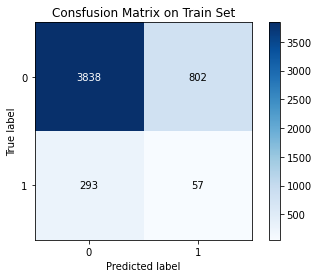

In [266]:
# plot the comfusion matrix  in the train set 

skplt.metrics.plot_confusion_matrix(y_train,y_train_pred, 
                                    normalize=False,
                                    title="Consfusion Matrix on Train Set")
plt.show()

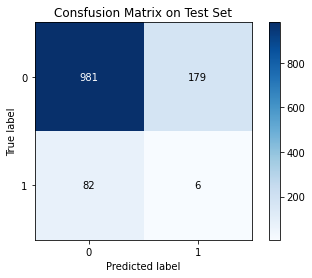

In [267]:
# plot the comfusion matrix  in the test set 

skplt.metrics.plot_confusion_matrix(y_test,y_test_pred, 
                                    normalize=False,
                                    title="Consfusion Matrix on Test Set")
plt.show()

## Autoenconder - com PCA nos dados

In [268]:
X_train_pca.shape

(4990, 5)

In [269]:
X_train.shape

(4990, 360)

In [270]:
# train AutoEncoder detector
clf_name = 'AutoEncoder'
clf_AE = AutoEncoder(hidden_neurons=[5, 2, 2, 5] ,epochs=epochs, contamination=contamination)
clf_AE.fit(X_train_pca)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 5)                 30        
_________________________________________________________________
dropout_6 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 30        
_________________________________________________________________
dropout_7 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 30        
_________________________________________________________________
dropout_8 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                

AutoEncoder(batch_size=32, contamination=0.172, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[5, 2, 2, 5],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7fc2eaf55378>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [271]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf_AE.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf_AE.decision_scores_  # raw outlier scores

In [272]:
# get the prediction on the test data
y_test_pred = clf_AE.predict(X_test_pca)  # outlier labels (0 or 1)
y_test_scores = clf_AE.decision_function(X_test_pca)  # outlier scores 

In [273]:
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
AutoEncoder ROC:0.5167, precision @ rank n:0.0886

On Test Data:
AutoEncoder ROC:0.5014, precision @ rank n:0.0455


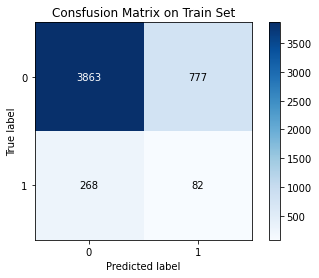

In [274]:
# plot the comfusion matrix  in the train set 

skplt.metrics.plot_confusion_matrix(y_train,y_train_pred, 
                                    normalize=False,
                                    title="Consfusion Matrix on Train Set")
plt.show()

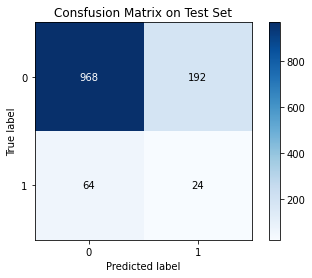

In [275]:
# plot the comfusion matrix  in the test set 

skplt.metrics.plot_confusion_matrix(y_test,y_test_pred, 
                                    normalize=False,
                                    title="Consfusion Matrix on Test Set")
plt.show()

## PCA

In [ ]:
from pyod.models.pca import PCA

In [ ]:
# train PCA detector
clf_name = 'PCA'
clf = PCA(n_components=5, contamination=contamination)
clf.fit(X_train)

PCA(contamination=0.172, copy=True, iterated_power='auto', n_components=5,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [ ]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

In [ ]:
# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

In [ ]:
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
PCA ROC:0.5362, precision @ rank n:0.0771

On Test Data:
PCA ROC:0.4826, precision @ rank n:0.0114


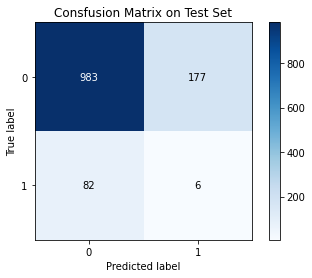

In [ ]:
# plot the comfusion matrix  in the test set 

skplt.metrics.plot_confusion_matrix(y_test,y_test_pred, 
                                    normalize=False,
                                    title="Consfusion Matrix on Test Set")
plt.show()

## Dados escalonados e com PCA

In [291]:
X_pca = pca.fit_transform(X)

In [292]:
type(X_pca)

numpy.ndarray

In [293]:
X_pca[1,:]

array([-16.83347684,   1.1621467 ,  -1.36189507,   0.07486192,
         1.17554355])

In [294]:
# Standardizing the features
X_pca = StandardScaler().fit_transform(X_pca)

In [295]:
X_pca[1,:]

array([-1.07385221,  0.11958695, -0.43734419,  0.03849371,  0.83415212])

In [296]:
X_pca = pd.DataFrame(X_pca)
X_pca.columns=['PC1','PC2', 'PC3', 'PC4','PC5']
X_pca.head()

,PC1,PC2,PC3,PC4,PC5
0,0.331654,1.140573,-0.301283,-0.503520,0.555624
1,-1.073852,0.119587,-0.437344,0.038494,0.834152
2,0.359290,1.357729,-0.490669,-0.312538,0.516730
3,-1.091633,0.240479,-0.334975,-0.105242,1.210932
4,0.331647,1.396988,-0.904358,0.089955,0.404607


In [297]:
pca.explained_variance_ratio_

array([0.68448538, 0.26306308, 0.02701134, 0.01053532, 0.00553213])

In [298]:
#split the data into train and test 
X_train_pca, X_test_pca, y_train,y_test = train_test_split(X_pca,y, test_size = 0.2, stratify=y, random_state=42 )

Esse escolonamento e PCA não funcionou melhor que o PCA apenas

## Referências

In [ ]:
!pip freeze > requirements.txt

https://www.kaggle.com/matheusfacure/semi-supervised-anomaly-detection-survey

https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/

https://medium.com/analytics-vidhya/introduction-to-anomaly-detection-using-machine-learning-with-a-case-study-part-two-f78243f74d2f

https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd